Primeira parte:
    • Representação (genótipo): string de bits #OK
    • Recombinação: “cut-and-crossfill” crossover #OK
    • Probabilidade de Recombinação: 90%
    • Mutação: troca de genes #OK
    • Probabilidade de Mutação: 40%
    • Seleção de pais: ranking - Melhor de 2 de 5 escolhidos aleatoriamente #OK
    • Seleção de sobreviventes: substituição do pior
    • Tamanho da população: 100 #OK
    • Número de filhos gerados: 2
    • Inicialização: aleatória #OK
    • Condição de término: Encontrar a solução, ou 10.000 avaliações de fitness #OK
    • Fitness #OK

In [80]:
from IPython.display import Image

In [81]:
from random import randint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
populationSize = 100

### Funções auxiliares

In [3]:
def truncate(n):
    return int(n * 10000) / 10000

In [4]:
def run30():
    aux = []
    print('Executando: ', end= ' ')
    for x in range(0,30):
        print(x, end=' ')
        chess, results = generateSolution()
        aux.append(results[-1])
    return pd.DataFrame(aux)

In [5]:
def generateScatterPlot(df):
    plt.figure(figsize=(15,4))
    ax = sns.scatterplot(data= df, x='iteracao', y = 'meanFitness')
    ax.set_title('Média do fitness por execução')
    ax.set_xlabel('Quantidade de iterações')
    ax.set_ylabel('Fitness médio')

In [6]:
def generateLinearPlot(df):
    plt.figure(figsize=(15,4))
    ax = sns.lineplot(data= df, x='iteracao', y = 'meanFitness')
    ax.set_title('Média do fitness por execução')
    ax.set_xlabel('Quantidade de iterações')
    ax.set_ylabel('Fitness médio')

In [7]:
def binaryToDecimal(binary): 
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal

In [8]:
def sortPopulation(population):
    # Ordena uma população pelo seu valor de fitness
    population.sort(key=lambda x:x['fitnessValue'])
    return population

In [9]:
def printChess(individual):
    aux = []
    for queen in individual['individual']:
        aux.append(binaryToDecimal(int(queen)))
    for x in range(0,8):
        for y in range(0,8):
            if y == aux[x]:
                print('1', end=' ')
            else:
                print('0', end = ' ')
        print('\n')

### Calcular fitness médio

In [10]:
def meanFitness(population):
    aux = 0
    for individual in population:
        aux += individual['fitnessValue']
    return aux/populationSize

### Criar população

In [11]:
def generateChess():
    aux = []
    while(len(aux) != 8):
        value = generateQueen()
        if not value in aux:
            aux.append(value)
    return aux

In [12]:
def generateQueen():
    queenPosition = ''
    for bitPosition in range(1,4):
        queenPosition += str(randint(0,1))
    return queenPosition

In [13]:
def generatePopulation():
    aux = []
    for populationMember in range(populationSize):
        aux.append({'individual': generateChess() , 'fitnessValue': -1 }) 
        #Cria um objeto composto do individuo e seu valor de fitness    
    return aux

### Quantidade de 'choques'

In [14]:
# Se duas rainhas estiverem na mesma coluna ### OK
def columnThreaten(individual):
    threatenColumn = 0
    for column in range(0,8):
        binaryColumn = np.binary_repr(column, width=3)
        if individual.count(binaryColumn) >= 2:
            threatenColumn += 1
    return threatenColumn

In [15]:
# Se duas rainhas estiverem na mesma diagonal
def diagonalThreaten(individual):
    deltaRow = 0
    deltaCol = 0
    threatenDiagonal = 0
    for x in range(0,8):
        for y in range(0,8):
            if x != y:
                deltaRow = abs(x-y)
                deltaCol = abs(binaryToDecimal(int(individual[x])) - binaryToDecimal(int(individual[y])))
                if (deltaRow == deltaCol):
                    threatenDiagonal += 1
    return threatenDiagonal/4

### Calculo do fitness

In [16]:
def fitnessIndividual(individual):
    value = 1 / (1 + (columnThreaten(individual) + diagonalThreaten(individual)))
    return value

In [17]:
def fitness(population):
    fitnessValue = []
    for individual in population:
        individual['fitnessValue'] = fitnessIndividual(individual['individual'])

#### O valor do fitness será dado pela função 1/1+qntdChoques(tabuleiro)
#### Queremos aumentar esse valor de fitness

### Mutação

Escolher um individuo(tabuleiro) aleatório e trocar a posição de uma rainha

In [18]:
def mutationSwap(individual):
    posicaoRainhaEscolhida = randint(0,7) ### A rainha que tera seu valor alterado
    valorNovaRainha = generateQueen() ##
    posicaoRainha2 = individual['individual'].index(valorNovaRainha)
    #### Trocar os valores da posicao da rainhaEscolhida com a Rainha 2
    aux = individual['individual'][posicaoRainhaEscolhida]
    individual['individual'][posicaoRainhaEscolhida] = individual['individual'][posicaoRainha2]
    individual['individual'][posicaoRainha2] = aux
    return individual

### Seleção de pais

In [19]:
def chooseRandomIndividuals(population):
    aux = []
    for i in range(0,5):
        value = randint(0,populationSize-1)
        aux.append(population[value])
    return aux

In [20]:
def selectParents(population):
    parents = chooseRandomIndividuals(population) #Array de objetos onde os elementos são os individuos e o valor do fitness
    parents = sortPopulation(parents) # Ordenando os pais de acordo com o fitnessValue
    return (parents[-2], parents[-1]) #Retornando os dois ultimos elementos da lista que são os com melhores fitness

### Seleção dos sobreviventes

#### Remover os dois menos adaptados da população

In [21]:
def replaceElements(population, filho1, filho2):
    aux = sortPopulation(population)
    aux[0] = filho1
    aux[1] = filho2
    return aux

### Recombinação: “cut-and-crossfill”

In [22]:
def copyFirstParent(parent, point):
    son = []
    for x in range(0,point+1): # Se o primeiro pai for escolhido o filho recebera primeiro os genes dele
            son.append(parent['individual'][x])
    return son

In [23]:
def generateParentTwoAux(parent, point):
    aux = []
    for x in range(point+1, 8):
        aux.append(parent['individual'][x])
    for x in range(0, point+1):
        aux.append(parent['individual'][x])
    return aux

In [24]:
def insertValuesSecondParent(parent, point, son):
    parentCircular = generateParentTwoAux(parent, point)
    while(len(son) != 8):
            for x in parentCircular:
                if not x in son: # Se o valor do 2 pai ainda não existe no filho insere
                    son.append(x)
    return {'individual': son, 'fitnessValue': -1}
        

In [25]:
def recombination(parent_one, parent_two):
    son = []
    point = randint(0,7) # Escolher uma posição para executar
    chooseFirst = randint(0,1)
    if (chooseFirst == 0):
        son = copyFirstParent(parent_one, point) # Se o primeiro pai for escolhido o filho recebera primeiro os genes dele
        return insertValuesSecondParent(parent_two, point, son)
    else:
        son = copyFirstParent(parent_two, point) # Se o segundo pai for escolhido o filho recebera primeiro os genes dele
        return insertValuesSecondParent(parent_one, point, son)

### Condição de parada

In [26]:
def lookingForFitnessMax(population):
    for individual in population:
        if individual['fitnessValue'] >= 1:
            return True

In [27]:
def maxIndividual(population):
    for individual in population:
        if individual['fitnessValue'] >= 1:
            return individual

## Gerar Solução

In [28]:
def generateSolution():
    iteracaoMeanFitness = []
    population = generatePopulation()
    fitness(population)
    i = 0
    while (i < 10000) :
        iteracaoMeanFitness.append({'iteracao': i, 'meanFitness': meanFitness(population)})
        if lookingForFitnessMax(population) == True:
            break
        pai1, pai2 = selectParents(population)
        filho1 = recombination(pai1,pai2)
        filho2 = recombination(pai1,pai2)
        filho1_mutacao = mutationSwap(filho2)
        filho2_mutacao = mutationSwap(filho2)
        fitness(population)
        population = replaceElements(population, filho1_mutacao, filho2_mutacao)
        i += 1
    return maxIndividual(population), iteracaoMeanFitness

#### Analisando uma solução

In [29]:
individuo, iteracao_fitness = generateSolution()

In [30]:
individuo

{'individual': ['101', '010', '000', '111', '100', '001', '011', '110'],
 'fitnessValue': 1.0}

In [31]:
iteracao_fitness

[{'iteracao': 0, 'meanFitness': 0.31621595071595043},
 {'iteracao': 1, 'meanFitness': 0.2930108225108224},
 {'iteracao': 2, 'meanFitness': 0.2952402597402596},
 {'iteracao': 3, 'meanFitness': 0.29604834054834045},
 {'iteracao': 4, 'meanFitness': 0.2979444444444443},
 {'iteracao': 5, 'meanFitness': 0.30061111111111094},
 {'iteracao': 6, 'meanFitness': 0.30161111111111094},
 {'iteracao': 7, 'meanFitness': 0.30288095238095225},
 {'iteracao': 8, 'meanFitness': 0.3084365079365078},
 {'iteracao': 9, 'meanFitness': 0.3089920634920633},
 {'iteracao': 10, 'meanFitness': 0.3089920634920633},
 {'iteracao': 11, 'meanFitness': 0.3089920634920633},
 {'iteracao': 12, 'meanFitness': 0.3125476190476189},
 {'iteracao': 13, 'meanFitness': 0.3161031746031744},
 {'iteracao': 14, 'meanFitness': 0.3170952380952379},
 {'iteracao': 15, 'meanFitness': 0.3178095238095236},
 {'iteracao': 16, 'meanFitness': 0.31947619047619025},
 {'iteracao': 17, 'meanFitness': 0.32019047619047597},
 {'iteracao': 18, 'meanFitness'

Os individuos na metade da execução elas começam ‘a subir as montanhas’ em busca dos máximos locais e no fim elas se localizam em pontos de máximos locais e globais.

Text(0, 0.5, 'Fitness médio da população')

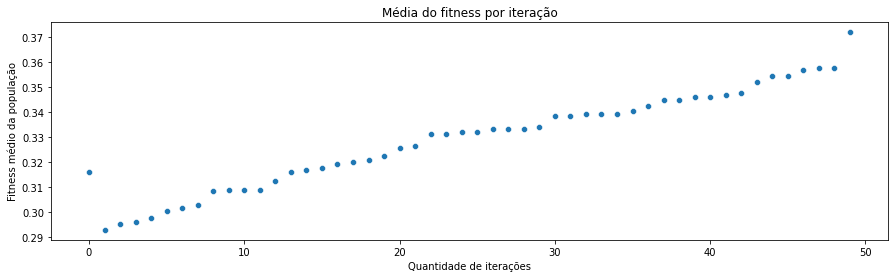

In [32]:
df = pd.DataFrame(iteracao_fitness)
plt.figure(figsize=(15,4))
ax = sns.scatterplot(data= df, x='iteracao', y = 'meanFitness')
ax.set_title('Média do fitness por iteração')
ax.set_xlabel('Quantidade de iterações')
ax.set_ylabel('Fitness médio da população')

# Parte I

Na parte 1 do projeto foi solicitado que desenvolvessemos uma solução usando algoritmos genéticos para o problema das 8 rainhas. Com as seguintes especificações iniciais:
   * Representação (genótipo): string de bits 
   * Recombinação: “cut-and-crossfill” crossover 
   * Probabilidade de Recombinação: 90%
   * Mutação: troca de genes #
   * Probabilidade de Mutação: 40%
   * Seleção de pais: ranking - Melhor de 2 de 5 escolhidos aleatoriamente #
   *  Seleção de sobreviventes: substituição do pior
   *  Tamanho da população: 100 
   *  Número de filhos gerados: 2
   *  Inicialização: aleatória 
   *  Condição de término: Encontrar a solução, ou 10.000 avaliações de fitness 
   * Fitness 

#### hipótese
Como o problema não possui um grau de dificuldade muito alta é esperado que a média de iterações seja baixa, outros fatores como a seleção de pais por ranking também auxilia a manter esse número de iteraçẽos baixo desde que sempre estamos escolhendo os individuos que possuem os melhores fitness, em outros problemas isso acarretaria na chance de encontrarmos máximos locais mas como só precisamos de uma única solução não importa se de fato ela é a melhor solução entre todas as soluções.
É esperado que o fitness médio não seja alto por causa das condiçoes de parada do problema precisamos apenas de uma única solução.

### Avaliação

In [33]:
df = run30()

Executando:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [34]:
print('Solucões encontradas na primeira iteração: ', len(df.loc[df['iteracao'] == 0]))

Solucões encontradas na primeira iteração:  8


#### Analisando as iterações

In [35]:
df.loc[:,'iteracao'].describe()

count     30.000000
mean     188.666667
std      172.941555
min        0.000000
25%       15.250000
50%      159.500000
75%      291.500000
max      648.000000
Name: iteracao, dtype: float64

#### Analisando o fitness médio por iteração

In [36]:
df.loc[:,'meanFitness'].describe()

count    30.000000
mean      0.448214
std       0.091979
min       0.308520
25%       0.352438
50%       0.475000
75%       0.521500
max       0.636667
Name: meanFitness, dtype: float64

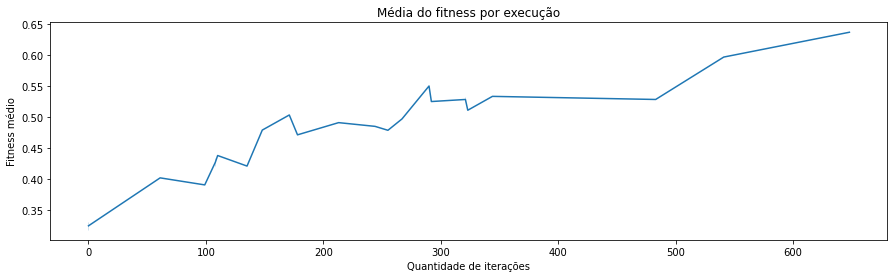

In [37]:
generateLinearPlot(df)

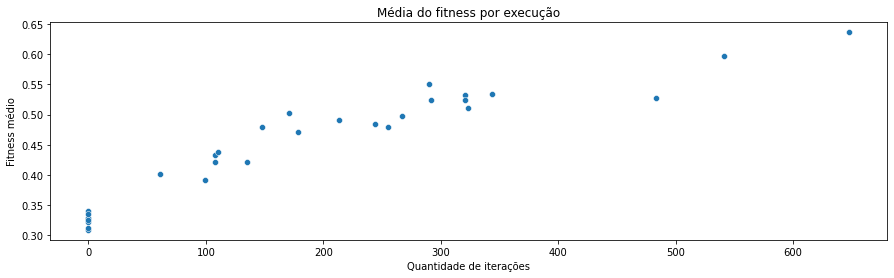

In [38]:
generateScatterPlot(df)

## Quantas iterações seriam necessarias para todos terem fitness = 1 ?

In [43]:
def allFitnessOne(populacao):
    aux = 0
    for individuo in populacao:
        if individuo['fitnessValue'] == 1:
            aux +=1
    return aux

In [54]:
def generateSolutionMAX():
    populationSize = 100
    iteracaoMeanFitness = []
    population = generatePopulation()
    fitness(population)
    i = 0
    individuosFitnessOne = allFitnessOne(population)
    while (individuosFitnessOne < populationSize) :
        #print('Iteração número: ', i, end= ' ')
        iteracaoMeanFitness.append({'iteracao': i, 'meanFitness': meanFitness(population)})
        print('Quantidade de individuos com fitness 1: ', individuosFitnessOne, ', iteração: ', i, ', fitness médio da população : ',meanFitness(population))
        #print('Iteração: ', i , 'meanFitness: ', meanFitness(population))
        pai1, pai2 = selectParents(population)
        filho1 = recombination(pai1,pai2)
        filho2 = recombination(pai1,pai2)
        filho1_mutacao = mutationSwap(filho2)
        filho2_mutacao = mutationSwap(filho2)
        fitness(population)
        population = replaceElements(population, filho1_mutacao, filho2_mutacao)
        i += 1
        individuosFitnessOne = allFitnessOne(population)
    return maxIndividual(population), iteracaoMeanFitness

In [55]:
generateSolutionMAX()

Quantidade de individuos com fitness 1:  0 , iteração:  0 , fitness médio da população :  0.3065994283494281
Quantidade de individuos com fitness 1:  0 , iteração:  1 , fitness médio da população :  0.28401609501609487
Quantidade de individuos com fitness 1:  0 , iteração:  2 , fitness médio da população :  0.28881096681096663
Quantidade de individuos com fitness 1:  0 , iteração:  3 , fitness médio da população :  0.28881096681096663
Quantidade de individuos com fitness 1:  0 , iteração:  4 , fitness médio da população :  0.2908888888888887
Quantidade de individuos com fitness 1:  0 , iteração:  5 , fitness médio da população :  0.2918888888888887
Quantidade de individuos com fitness 1:  0 , iteração:  6 , fitness médio da população :  0.2928888888888887
Quantidade de individuos com fitness 1:  0 , iteração:  7 , fitness médio da população :  0.29555555555555535
Quantidade de individuos com fitness 1:  0 , iteração:  8 , fitness médio da população :  0.30155555555555535
Quantidade de 

Quantidade de individuos com fitness 1:  2 , iteração:  87 , fitness médio da população :  0.40833333333333305
Quantidade de individuos com fitness 1:  2 , iteração:  88 , fitness médio da população :  0.40833333333333305
Quantidade de individuos com fitness 1:  2 , iteração:  89 , fitness médio da população :  0.40966666666666635
Quantidade de individuos com fitness 1:  2 , iteração:  90 , fitness médio da população :  0.40966666666666635
Quantidade de individuos com fitness 1:  2 , iteração:  91 , fitness médio da população :  0.40966666666666635
Quantidade de individuos com fitness 1:  2 , iteração:  92 , fitness médio da população :  0.40966666666666635
Quantidade de individuos com fitness 1:  2 , iteração:  93 , fitness médio da população :  0.40966666666666635
Quantidade de individuos com fitness 1:  2 , iteração:  94 , fitness médio da população :  0.40966666666666635
Quantidade de individuos com fitness 1:  2 , iteração:  95 , fitness médio da população :  0.41099999999999964
Q

Quantidade de individuos com fitness 1:  2 , iteração:  183 , fitness médio da população :  0.44366666666666654
Quantidade de individuos com fitness 1:  2 , iteração:  184 , fitness médio da população :  0.44366666666666654
Quantidade de individuos com fitness 1:  2 , iteração:  185 , fitness médio da população :  0.44366666666666654
Quantidade de individuos com fitness 1:  2 , iteração:  186 , fitness médio da população :  0.44366666666666654
Quantidade de individuos com fitness 1:  2 , iteração:  187 , fitness médio da população :  0.44366666666666654
Quantidade de individuos com fitness 1:  2 , iteração:  188 , fitness médio da população :  0.44366666666666654
Quantidade de individuos com fitness 1:  2 , iteração:  189 , fitness médio da população :  0.44366666666666654
Quantidade de individuos com fitness 1:  2 , iteração:  190 , fitness médio da população :  0.44566666666666654
Quantidade de individuos com fitness 1:  2 , iteração:  191 , fitness médio da população :  0.4456666666

Quantidade de individuos com fitness 1:  2 , iteração:  284 , fitness médio da população :  0.46899999999999986
Quantidade de individuos com fitness 1:  2 , iteração:  285 , fitness médio da população :  0.46899999999999986
Quantidade de individuos com fitness 1:  2 , iteração:  286 , fitness médio da população :  0.46899999999999986
Quantidade de individuos com fitness 1:  2 , iteração:  287 , fitness médio da população :  0.4743333333333331
Quantidade de individuos com fitness 1:  2 , iteração:  288 , fitness médio da população :  0.4743333333333331
Quantidade de individuos com fitness 1:  2 , iteração:  289 , fitness médio da população :  0.4743333333333331
Quantidade de individuos com fitness 1:  2 , iteração:  290 , fitness médio da população :  0.4743333333333331
Quantidade de individuos com fitness 1:  2 , iteração:  291 , fitness médio da população :  0.4743333333333331
Quantidade de individuos com fitness 1:  2 , iteração:  292 , fitness médio da população :  0.474333333333333

Quantidade de individuos com fitness 1:  4 , iteração:  366 , fitness médio da população :  0.518333333333333
Quantidade de individuos com fitness 1:  4 , iteração:  367 , fitness médio da população :  0.5216666666666662
Quantidade de individuos com fitness 1:  4 , iteração:  368 , fitness médio da população :  0.5249999999999995
Quantidade de individuos com fitness 1:  4 , iteração:  369 , fitness médio da população :  0.5249999999999995
Quantidade de individuos com fitness 1:  4 , iteração:  370 , fitness médio da população :  0.5249999999999995
Quantidade de individuos com fitness 1:  4 , iteração:  371 , fitness médio da população :  0.5249999999999995
Quantidade de individuos com fitness 1:  4 , iteração:  372 , fitness médio da população :  0.5249999999999995
Quantidade de individuos com fitness 1:  4 , iteração:  373 , fitness médio da população :  0.5249999999999995
Quantidade de individuos com fitness 1:  4 , iteração:  374 , fitness médio da população :  0.5249999999999995
Qu

Quantidade de individuos com fitness 1:  4 , iteração:  448 , fitness médio da população :  0.5316666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  449 , fitness médio da população :  0.5316666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  450 , fitness médio da população :  0.5316666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  451 , fitness médio da população :  0.5316666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  452 , fitness médio da população :  0.5316666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  453 , fitness médio da população :  0.5316666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  454 , fitness médio da população :  0.5316666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  455 , fitness médio da população :  0.5316666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  456 , fitness médio da população :  0.5316666666666661
Q

Quantidade de individuos com fitness 1:  4 , iteração:  536 , fitness médio da população :  0.5416666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  537 , fitness médio da população :  0.5416666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  538 , fitness médio da população :  0.5416666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  539 , fitness médio da população :  0.5416666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  540 , fitness médio da população :  0.5416666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  541 , fitness médio da população :  0.5416666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  542 , fitness médio da população :  0.5416666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  543 , fitness médio da população :  0.5416666666666661
Quantidade de individuos com fitness 1:  4 , iteração:  544 , fitness médio da população :  0.5416666666666661
Q

Quantidade de individuos com fitness 1:  6 , iteração:  627 , fitness médio da população :  0.5749999999999995
Quantidade de individuos com fitness 1:  6 , iteração:  628 , fitness médio da população :  0.5749999999999995
Quantidade de individuos com fitness 1:  6 , iteração:  629 , fitness médio da população :  0.5749999999999995
Quantidade de individuos com fitness 1:  6 , iteração:  630 , fitness médio da população :  0.5749999999999995
Quantidade de individuos com fitness 1:  6 , iteração:  631 , fitness médio da população :  0.5749999999999995
Quantidade de individuos com fitness 1:  6 , iteração:  632 , fitness médio da população :  0.5749999999999995
Quantidade de individuos com fitness 1:  6 , iteração:  633 , fitness médio da população :  0.5749999999999995
Quantidade de individuos com fitness 1:  6 , iteração:  634 , fitness médio da população :  0.5749999999999995
Quantidade de individuos com fitness 1:  6 , iteração:  635 , fitness médio da população :  0.5783333333333328
Q

Quantidade de individuos com fitness 1:  8 , iteração:  746 , fitness médio da população :  0.6183333333333327
Quantidade de individuos com fitness 1:  8 , iteração:  747 , fitness médio da população :  0.6183333333333327
Quantidade de individuos com fitness 1:  8 , iteração:  748 , fitness médio da população :  0.6183333333333327
Quantidade de individuos com fitness 1:  8 , iteração:  749 , fitness médio da população :  0.6183333333333327
Quantidade de individuos com fitness 1:  8 , iteração:  750 , fitness médio da população :  0.6183333333333327
Quantidade de individuos com fitness 1:  8 , iteração:  751 , fitness médio da população :  0.6183333333333327
Quantidade de individuos com fitness 1:  8 , iteração:  752 , fitness médio da população :  0.6183333333333327
Quantidade de individuos com fitness 1:  8 , iteração:  753 , fitness médio da população :  0.6183333333333327
Quantidade de individuos com fitness 1:  8 , iteração:  754 , fitness médio da população :  0.6183333333333327
Q

Quantidade de individuos com fitness 1:  10 , iteração:  858 , fitness médio da população :  0.651666666666666
Quantidade de individuos com fitness 1:  10 , iteração:  859 , fitness médio da população :  0.651666666666666
Quantidade de individuos com fitness 1:  10 , iteração:  860 , fitness médio da população :  0.651666666666666
Quantidade de individuos com fitness 1:  10 , iteração:  861 , fitness médio da população :  0.651666666666666
Quantidade de individuos com fitness 1:  10 , iteração:  862 , fitness médio da população :  0.651666666666666
Quantidade de individuos com fitness 1:  10 , iteração:  863 , fitness médio da população :  0.651666666666666
Quantidade de individuos com fitness 1:  10 , iteração:  864 , fitness médio da população :  0.651666666666666
Quantidade de individuos com fitness 1:  10 , iteração:  865 , fitness médio da população :  0.6549999999999995
Quantidade de individuos com fitness 1:  10 , iteração:  866 , fitness médio da população :  0.6549999999999995

Quantidade de individuos com fitness 1:  14 , iteração:  963 , fitness médio da população :  0.6799999999999994
Quantidade de individuos com fitness 1:  14 , iteração:  964 , fitness médio da população :  0.6799999999999994
Quantidade de individuos com fitness 1:  14 , iteração:  965 , fitness médio da população :  0.6799999999999994
Quantidade de individuos com fitness 1:  14 , iteração:  966 , fitness médio da população :  0.6799999999999994
Quantidade de individuos com fitness 1:  14 , iteração:  967 , fitness médio da população :  0.6799999999999994
Quantidade de individuos com fitness 1:  14 , iteração:  968 , fitness médio da população :  0.6799999999999994
Quantidade de individuos com fitness 1:  14 , iteração:  969 , fitness médio da população :  0.6799999999999994
Quantidade de individuos com fitness 1:  14 , iteração:  970 , fitness médio da população :  0.6799999999999994
Quantidade de individuos com fitness 1:  14 , iteração:  971 , fitness médio da população :  0.679999999

Quantidade de individuos com fitness 1:  16 , iteração:  1038 , fitness médio da população :  0.6866666666666661
Quantidade de individuos com fitness 1:  16 , iteração:  1039 , fitness médio da população :  0.6866666666666661
Quantidade de individuos com fitness 1:  16 , iteração:  1040 , fitness médio da população :  0.6866666666666661
Quantidade de individuos com fitness 1:  16 , iteração:  1041 , fitness médio da população :  0.6866666666666661
Quantidade de individuos com fitness 1:  16 , iteração:  1042 , fitness médio da população :  0.6866666666666661
Quantidade de individuos com fitness 1:  16 , iteração:  1043 , fitness médio da população :  0.6866666666666661
Quantidade de individuos com fitness 1:  16 , iteração:  1044 , fitness médio da população :  0.6866666666666661
Quantidade de individuos com fitness 1:  16 , iteração:  1045 , fitness médio da população :  0.6866666666666661
Quantidade de individuos com fitness 1:  16 , iteração:  1046 , fitness médio da população :  0.

Quantidade de individuos com fitness 1:  20 , iteração:  1140 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1141 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1142 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1143 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1144 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1145 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1146 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1147 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1148 , fitness médio da população :  0.

Quantidade de individuos com fitness 1:  20 , iteração:  1245 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1246 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1247 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1248 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1249 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1250 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1251 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1252 , fitness médio da população :  0.6999999999999996
Quantidade de individuos com fitness 1:  20 , iteração:  1253 , fitness médio da população :  0.

Quantidade de individuos com fitness 1:  26 , iteração:  1328 , fitness médio da população :  0.7199999999999998
Quantidade de individuos com fitness 1:  26 , iteração:  1329 , fitness médio da população :  0.7199999999999998
Quantidade de individuos com fitness 1:  26 , iteração:  1330 , fitness médio da população :  0.7199999999999998
Quantidade de individuos com fitness 1:  26 , iteração:  1331 , fitness médio da população :  0.7199999999999998
Quantidade de individuos com fitness 1:  26 , iteração:  1332 , fitness médio da população :  0.7199999999999998
Quantidade de individuos com fitness 1:  26 , iteração:  1333 , fitness médio da população :  0.7199999999999998
Quantidade de individuos com fitness 1:  26 , iteração:  1334 , fitness médio da população :  0.7199999999999998
Quantidade de individuos com fitness 1:  26 , iteração:  1335 , fitness médio da população :  0.7199999999999998
Quantidade de individuos com fitness 1:  26 , iteração:  1336 , fitness médio da população :  0.

Quantidade de individuos com fitness 1:  28 , iteração:  1411 , fitness médio da população :  0.7266666666666665
Quantidade de individuos com fitness 1:  28 , iteração:  1412 , fitness médio da população :  0.7266666666666665
Quantidade de individuos com fitness 1:  28 , iteração:  1413 , fitness médio da população :  0.7266666666666665
Quantidade de individuos com fitness 1:  28 , iteração:  1414 , fitness médio da população :  0.7266666666666665
Quantidade de individuos com fitness 1:  28 , iteração:  1415 , fitness médio da população :  0.7266666666666665
Quantidade de individuos com fitness 1:  28 , iteração:  1416 , fitness médio da população :  0.7266666666666665
Quantidade de individuos com fitness 1:  28 , iteração:  1417 , fitness médio da população :  0.7266666666666665
Quantidade de individuos com fitness 1:  28 , iteração:  1418 , fitness médio da população :  0.7266666666666665
Quantidade de individuos com fitness 1:  28 , iteração:  1419 , fitness médio da população :  0.

Quantidade de individuos com fitness 1:  32 , iteração:  1485 , fitness médio da população :  0.7399999999999999
Quantidade de individuos com fitness 1:  32 , iteração:  1486 , fitness médio da população :  0.7399999999999999
Quantidade de individuos com fitness 1:  32 , iteração:  1487 , fitness médio da população :  0.7399999999999999
Quantidade de individuos com fitness 1:  32 , iteração:  1488 , fitness médio da população :  0.7399999999999999
Quantidade de individuos com fitness 1:  32 , iteração:  1489 , fitness médio da população :  0.7399999999999999
Quantidade de individuos com fitness 1:  32 , iteração:  1490 , fitness médio da população :  0.7399999999999999
Quantidade de individuos com fitness 1:  32 , iteração:  1491 , fitness médio da população :  0.7399999999999999
Quantidade de individuos com fitness 1:  32 , iteração:  1492 , fitness médio da população :  0.7399999999999999
Quantidade de individuos com fitness 1:  32 , iteração:  1493 , fitness médio da população :  0.

Quantidade de individuos com fitness 1:  34 , iteração:  1578 , fitness médio da população :  0.7466666666666666
Quantidade de individuos com fitness 1:  34 , iteração:  1579 , fitness médio da população :  0.7466666666666666
Quantidade de individuos com fitness 1:  34 , iteração:  1580 , fitness médio da população :  0.7466666666666666
Quantidade de individuos com fitness 1:  34 , iteração:  1581 , fitness médio da população :  0.7466666666666666
Quantidade de individuos com fitness 1:  34 , iteração:  1582 , fitness médio da população :  0.7466666666666666
Quantidade de individuos com fitness 1:  34 , iteração:  1583 , fitness médio da população :  0.7466666666666666
Quantidade de individuos com fitness 1:  34 , iteração:  1584 , fitness médio da população :  0.7466666666666666
Quantidade de individuos com fitness 1:  34 , iteração:  1585 , fitness médio da população :  0.7466666666666666
Quantidade de individuos com fitness 1:  34 , iteração:  1586 , fitness médio da população :  0.

Quantidade de individuos com fitness 1:  42 , iteração:  1719 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1720 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1721 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1722 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1723 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1724 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1725 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1726 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1727 , fitness médio da população :  0.

Quantidade de individuos com fitness 1:  42 , iteração:  1793 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1794 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1795 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1796 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1797 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1798 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1799 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1800 , fitness médio da população :  0.7733333333333334
Quantidade de individuos com fitness 1:  42 , iteração:  1801 , fitness médio da população :  0.

Quantidade de individuos com fitness 1:  54 , iteração:  1893 , fitness médio da população :  0.8133333333333335
Quantidade de individuos com fitness 1:  54 , iteração:  1894 , fitness médio da população :  0.8133333333333335
Quantidade de individuos com fitness 1:  54 , iteração:  1895 , fitness médio da população :  0.8133333333333335
Quantidade de individuos com fitness 1:  54 , iteração:  1896 , fitness médio da população :  0.8133333333333335
Quantidade de individuos com fitness 1:  54 , iteração:  1897 , fitness médio da população :  0.8133333333333335
Quantidade de individuos com fitness 1:  54 , iteração:  1898 , fitness médio da população :  0.8133333333333335
Quantidade de individuos com fitness 1:  54 , iteração:  1899 , fitness médio da população :  0.8133333333333335
Quantidade de individuos com fitness 1:  56 , iteração:  1900 , fitness médio da população :  0.8200000000000002
Quantidade de individuos com fitness 1:  56 , iteração:  1901 , fitness médio da população :  0.

Quantidade de individuos com fitness 1:  62 , iteração:  1994 , fitness médio da população :  0.84
Quantidade de individuos com fitness 1:  62 , iteração:  1995 , fitness médio da população :  0.84
Quantidade de individuos com fitness 1:  62 , iteração:  1996 , fitness médio da população :  0.84
Quantidade de individuos com fitness 1:  62 , iteração:  1997 , fitness médio da população :  0.84
Quantidade de individuos com fitness 1:  62 , iteração:  1998 , fitness médio da população :  0.84
Quantidade de individuos com fitness 1:  62 , iteração:  1999 , fitness médio da população :  0.84
Quantidade de individuos com fitness 1:  62 , iteração:  2000 , fitness médio da população :  0.84
Quantidade de individuos com fitness 1:  62 , iteração:  2001 , fitness médio da população :  0.84
Quantidade de individuos com fitness 1:  62 , iteração:  2002 , fitness médio da população :  0.84
Quantidade de individuos com fitness 1:  62 , iteração:  2003 , fitness médio da população :  0.84
Quantidade

Quantidade de individuos com fitness 1:  72 , iteração:  2132 , fitness médio da população :  0.8733333333333333
Quantidade de individuos com fitness 1:  72 , iteração:  2133 , fitness médio da população :  0.8733333333333333
Quantidade de individuos com fitness 1:  72 , iteração:  2134 , fitness médio da população :  0.8733333333333333
Quantidade de individuos com fitness 1:  72 , iteração:  2135 , fitness médio da população :  0.8733333333333333
Quantidade de individuos com fitness 1:  72 , iteração:  2136 , fitness médio da população :  0.8733333333333333
Quantidade de individuos com fitness 1:  72 , iteração:  2137 , fitness médio da população :  0.8733333333333333
Quantidade de individuos com fitness 1:  72 , iteração:  2138 , fitness médio da população :  0.8733333333333333
Quantidade de individuos com fitness 1:  72 , iteração:  2139 , fitness médio da população :  0.8733333333333333
Quantidade de individuos com fitness 1:  72 , iteração:  2140 , fitness médio da população :  0.

Quantidade de individuos com fitness 1:  74 , iteração:  2227 , fitness médio da população :  0.88
Quantidade de individuos com fitness 1:  74 , iteração:  2228 , fitness médio da população :  0.88
Quantidade de individuos com fitness 1:  74 , iteração:  2229 , fitness médio da população :  0.88
Quantidade de individuos com fitness 1:  74 , iteração:  2230 , fitness médio da população :  0.88
Quantidade de individuos com fitness 1:  74 , iteração:  2231 , fitness médio da população :  0.88
Quantidade de individuos com fitness 1:  74 , iteração:  2232 , fitness médio da população :  0.88
Quantidade de individuos com fitness 1:  74 , iteração:  2233 , fitness médio da população :  0.88
Quantidade de individuos com fitness 1:  74 , iteração:  2234 , fitness médio da população :  0.88
Quantidade de individuos com fitness 1:  74 , iteração:  2235 , fitness médio da população :  0.88
Quantidade de individuos com fitness 1:  74 , iteração:  2236 , fitness médio da população :  0.88
Quantidade

Quantidade de individuos com fitness 1:  84 , iteração:  2327 , fitness médio da população :  0.9133333333333334
Quantidade de individuos com fitness 1:  84 , iteração:  2328 , fitness médio da população :  0.9133333333333334
Quantidade de individuos com fitness 1:  84 , iteração:  2329 , fitness médio da população :  0.9133333333333334
Quantidade de individuos com fitness 1:  84 , iteração:  2330 , fitness médio da população :  0.9133333333333334
Quantidade de individuos com fitness 1:  84 , iteração:  2331 , fitness médio da população :  0.9133333333333334
Quantidade de individuos com fitness 1:  84 , iteração:  2332 , fitness médio da população :  0.9133333333333334
Quantidade de individuos com fitness 1:  84 , iteração:  2333 , fitness médio da população :  0.9133333333333334
Quantidade de individuos com fitness 1:  84 , iteração:  2334 , fitness médio da população :  0.9133333333333334
Quantidade de individuos com fitness 1:  84 , iteração:  2335 , fitness médio da população :  0.

Quantidade de individuos com fitness 1:  86 , iteração:  2462 , fitness médio da população :  0.92
Quantidade de individuos com fitness 1:  86 , iteração:  2463 , fitness médio da população :  0.92
Quantidade de individuos com fitness 1:  86 , iteração:  2464 , fitness médio da população :  0.92
Quantidade de individuos com fitness 1:  86 , iteração:  2465 , fitness médio da população :  0.92
Quantidade de individuos com fitness 1:  86 , iteração:  2466 , fitness médio da população :  0.92
Quantidade de individuos com fitness 1:  86 , iteração:  2467 , fitness médio da população :  0.92
Quantidade de individuos com fitness 1:  86 , iteração:  2468 , fitness médio da população :  0.92
Quantidade de individuos com fitness 1:  86 , iteração:  2469 , fitness médio da população :  0.92
Quantidade de individuos com fitness 1:  86 , iteração:  2470 , fitness médio da população :  0.92
Quantidade de individuos com fitness 1:  86 , iteração:  2471 , fitness médio da população :  0.92
Quantidade

Quantidade de individuos com fitness 1:  94 , iteração:  2565 , fitness médio da população :  0.9466666666666665
Quantidade de individuos com fitness 1:  94 , iteração:  2566 , fitness médio da população :  0.9466666666666665
Quantidade de individuos com fitness 1:  94 , iteração:  2567 , fitness médio da população :  0.9466666666666665
Quantidade de individuos com fitness 1:  94 , iteração:  2568 , fitness médio da população :  0.9466666666666665
Quantidade de individuos com fitness 1:  96 , iteração:  2569 , fitness médio da população :  0.9533333333333333
Quantidade de individuos com fitness 1:  96 , iteração:  2570 , fitness médio da população :  0.9533333333333333
Quantidade de individuos com fitness 1:  96 , iteração:  2571 , fitness médio da população :  0.9533333333333333
Quantidade de individuos com fitness 1:  98 , iteração:  2572 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2573 , fitness médio da população :  0.96
Quantidade 

Quantidade de individuos com fitness 1:  98 , iteração:  2660 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2661 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2662 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2663 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2664 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2665 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2666 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2667 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2668 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2669 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  2825 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2826 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2827 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2828 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2829 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2830 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2831 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2832 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2833 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2834 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  2909 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2910 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2911 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2912 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2913 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2914 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2915 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2916 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2917 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  2918 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  3064 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3065 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3066 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3067 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3068 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3069 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3070 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3071 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3072 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3073 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  3159 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3160 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3161 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3162 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3163 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3164 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3165 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3166 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3167 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3168 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  3242 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3243 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3244 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3245 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3246 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3247 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3248 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3249 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3250 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3251 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  3378 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3379 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3380 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3381 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3382 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3383 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3384 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3385 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3386 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3387 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  3492 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3493 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3494 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3495 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3496 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3497 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3498 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3499 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3500 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3501 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  3575 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3576 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3577 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3578 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3579 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3580 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3581 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3582 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3583 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3584 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  3658 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3659 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3660 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3661 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3662 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3663 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3664 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3665 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3666 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3667 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  3742 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3743 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3744 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3745 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3746 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3747 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3748 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3749 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3750 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3751 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  3908 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3909 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3910 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3911 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3912 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3913 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3914 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3915 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3916 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  3917 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  4075 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4076 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4077 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4078 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4079 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4080 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4081 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4082 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4083 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4084 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  4158 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4159 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4160 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4161 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4162 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4163 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4164 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4165 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4166 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4167 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  4241 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4242 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4243 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4244 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4245 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4246 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4247 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4248 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4249 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4250 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  4408 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4409 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4410 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4411 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4412 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4413 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4414 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4415 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4416 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4417 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  4491 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4492 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4493 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4494 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4495 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4496 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4497 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4498 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4499 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4500 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  4574 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4575 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4576 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4577 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4578 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4579 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4580 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4581 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4582 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4583 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  4657 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4658 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4659 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4660 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4661 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4662 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4663 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4664 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4665 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4666 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  4741 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4742 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4743 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4744 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4745 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4746 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4747 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4748 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4749 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4750 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  4824 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4825 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4826 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4827 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4828 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4829 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4830 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4831 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4832 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4833 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  4907 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4908 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4909 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4910 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4911 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4912 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4913 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4914 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4915 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4916 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  4990 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4991 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4992 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4993 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4994 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4995 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4996 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4997 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4998 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  4999 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  5074 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5075 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5076 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5077 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5078 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5079 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5080 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5081 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5082 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5083 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  5157 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5158 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5159 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5160 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5161 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5162 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5163 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5164 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5165 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5166 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  5240 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5241 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5242 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5243 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5244 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5245 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5246 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5247 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5248 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5249 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  5323 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5324 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5325 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5326 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5327 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5328 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5329 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5330 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5331 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5332 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  5407 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5408 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5409 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5410 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5411 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5412 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5413 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5414 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5415 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5416 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  5490 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5491 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5492 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5493 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5494 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5495 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5496 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5497 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5498 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5499 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  5573 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5574 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5575 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5576 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5577 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5578 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5579 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5580 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5581 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5582 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  5656 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5657 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5658 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5659 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5660 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5661 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5662 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5663 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5664 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5665 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  5740 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5741 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5742 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5743 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5744 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5745 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5746 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5747 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5748 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5749 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  5823 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5824 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5825 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5826 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5827 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5828 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5829 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5830 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5831 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5832 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  5906 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5907 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5908 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5909 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5910 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5911 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5912 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5913 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5914 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5915 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  5989 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5990 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5991 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5992 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5993 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5994 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5995 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5996 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5997 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  5998 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  6073 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6074 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6075 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6076 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6077 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6078 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6079 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6080 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6081 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6082 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  6156 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6157 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6158 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6159 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6160 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6161 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6162 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6163 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6164 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6165 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  6239 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6240 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6241 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6242 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6243 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6244 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6245 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6246 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6247 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6248 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  6322 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6323 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6324 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6325 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6326 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6327 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6328 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6329 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6330 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6331 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  6406 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6407 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6408 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6409 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6410 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6411 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6412 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6413 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6414 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6415 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  6489 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6490 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6491 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6492 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6493 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6494 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6495 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6496 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6497 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6498 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  6572 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6573 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6574 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6575 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6576 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6577 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6578 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6579 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6580 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6581 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  6655 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6656 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6657 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6658 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6659 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6660 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6661 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6662 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6663 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6664 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  6739 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6740 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6741 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6742 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6743 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6744 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6745 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6746 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6747 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6748 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  6822 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6823 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6824 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6825 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6826 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6827 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6828 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6829 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6830 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6831 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  6905 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6906 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6907 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6908 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6909 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6910 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6911 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6912 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6913 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6914 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  6988 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6989 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6990 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6991 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6992 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6993 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6994 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6995 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6996 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  6997 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  7072 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7073 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7074 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7075 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7076 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7077 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7078 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7079 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7080 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7081 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  7155 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7156 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7157 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7158 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7159 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7160 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7161 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7162 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7163 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7164 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  7238 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7239 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7240 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7241 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7242 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7243 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7244 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7245 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7246 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7247 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  7321 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7322 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7323 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7324 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7325 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7326 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7327 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7328 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7329 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7330 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  7405 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7406 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7407 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7408 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7409 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7410 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7411 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7412 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7413 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7414 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  7488 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7489 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7490 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7491 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7492 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7493 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7494 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7495 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7496 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7497 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  7571 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7572 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7573 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7574 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7575 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7576 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7577 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7578 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7579 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7580 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  7654 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7655 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7656 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7657 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7658 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7659 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7660 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7661 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7662 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7663 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  7738 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7739 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7740 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7741 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7742 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7743 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7744 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7745 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7746 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7747 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  7821 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7822 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7823 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7824 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7825 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7826 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7827 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7828 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7829 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7830 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  7904 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7905 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7906 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7907 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7908 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7909 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7910 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7911 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7912 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7913 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  7987 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7988 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7989 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7990 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7991 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7992 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7993 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7994 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7995 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  7996 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  8071 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8072 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8073 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8074 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8075 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8076 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8077 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8078 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8079 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8080 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  8154 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8155 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8156 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8157 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8158 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8159 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8160 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8161 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8162 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8163 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  8237 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8238 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8239 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8240 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8241 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8242 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8243 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8244 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8245 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8246 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  8320 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8321 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8322 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8323 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8324 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8325 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8326 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8327 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8328 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8329 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  8404 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8405 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8406 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8407 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8408 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8409 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8410 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8411 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8412 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8413 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  8487 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8488 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8489 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8490 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8491 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8492 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8493 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8494 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8495 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8496 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  8570 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8571 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8572 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8573 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8574 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8575 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8576 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8577 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8578 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8579 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  8653 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8654 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8655 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8656 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8657 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8658 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8659 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8660 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8661 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8662 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  8737 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8738 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8739 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8740 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8741 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8742 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8743 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8744 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8745 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8746 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  8820 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8821 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8822 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8823 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8824 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8825 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8826 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8827 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8828 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8829 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  8903 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8904 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8905 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8906 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8907 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8908 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8909 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8910 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8911 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8912 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  8986 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8987 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8988 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8989 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8990 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8991 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8992 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8993 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8994 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  8995 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  9070 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9071 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9072 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9073 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9074 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9075 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9076 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9077 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9078 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9079 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  9153 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9154 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9155 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9156 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9157 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9158 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9159 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9160 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9161 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9162 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  9236 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9237 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9238 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9239 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9240 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9241 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9242 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9243 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9244 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9245 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  9319 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9320 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9321 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9322 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9323 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9324 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9325 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9326 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9327 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9328 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  9403 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9404 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9405 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9406 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9407 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9408 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9409 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9410 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9411 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9412 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  9486 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9487 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9488 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9489 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9490 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9491 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9492 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9493 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9494 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9495 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  9569 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9570 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9571 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9572 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9573 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9574 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9575 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9576 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9577 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9578 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  9652 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9653 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9654 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9655 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9656 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9657 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9658 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9659 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9660 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9661 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  9736 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9737 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9738 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9739 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9740 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9741 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9742 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9743 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9744 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9745 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  9819 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9820 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9821 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9822 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9823 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9824 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9825 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9826 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9827 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9828 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  9902 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9903 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9904 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9905 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9906 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9907 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9908 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9909 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9910 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9911 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  9985 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9986 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9987 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9988 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9989 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9990 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9991 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9992 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9993 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  9994 , fitness médio da população :  0.96
Quantidade

Quantidade de individuos com fitness 1:  98 , iteração:  10069 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10070 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10071 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10072 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10073 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10074 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10075 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10076 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10077 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10078 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  10152 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10153 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10154 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10155 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10156 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10157 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10158 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10159 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10160 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10161 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  10235 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10236 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10237 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10238 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10239 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10240 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10241 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10242 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10243 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10244 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  10318 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10319 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10320 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10321 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10322 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10323 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10324 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10325 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10326 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10327 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  10402 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10403 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10404 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10405 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10406 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10407 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10408 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10409 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10410 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10411 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  10485 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10486 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10487 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10488 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10489 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10490 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10491 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10492 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10493 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10494 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  10568 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10569 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10570 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10571 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10572 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10573 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10574 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10575 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10576 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10577 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  10651 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10652 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10653 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10654 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10655 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10656 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10657 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10658 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10659 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10660 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  10735 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10736 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10737 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10738 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10739 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10740 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10741 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10742 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10743 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10744 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  10818 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10819 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10820 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10821 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10822 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10823 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10824 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10825 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10826 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10827 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  10901 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10902 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10903 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10904 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10905 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10906 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10907 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10908 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10909 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10910 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  10984 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10985 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10986 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10987 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10988 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10989 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10990 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10991 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10992 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  10993 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  11068 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11069 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11070 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11071 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11072 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11073 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11074 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11075 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11076 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11077 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  11151 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11152 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11153 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11154 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11155 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11156 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11157 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11158 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11159 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11160 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  11234 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11235 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11236 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11237 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11238 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11239 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11240 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11241 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11242 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11243 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  11317 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11318 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11319 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11320 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11321 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11322 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11323 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11324 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11325 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11326 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  11401 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11402 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11403 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11404 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11405 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11406 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11407 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11408 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11409 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11410 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  11484 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11485 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11486 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11487 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11488 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11489 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11490 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11491 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11492 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11493 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  11567 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11568 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11569 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11570 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11571 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11572 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11573 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11574 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11575 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11576 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  11650 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11651 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11652 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11653 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11654 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11655 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11656 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11657 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11658 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11659 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  11734 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11735 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11736 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11737 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11738 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11739 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11740 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11741 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11742 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11743 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  11817 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11818 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11819 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11820 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11821 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11822 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11823 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11824 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11825 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11826 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  11900 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11901 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11902 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11903 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11904 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11905 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11906 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11907 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11908 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11909 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  11983 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11984 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11985 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11986 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11987 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11988 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11989 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11990 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11991 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  11992 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  12067 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12068 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12069 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12070 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12071 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12072 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12073 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12074 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12075 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12076 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  12150 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12151 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12152 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12153 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12154 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12155 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12156 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12157 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12158 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12159 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  12233 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12234 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12235 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12236 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12237 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12238 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12239 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12240 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12241 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12242 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  12316 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12317 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12318 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12319 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12320 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12321 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12322 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12323 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12324 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12325 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  12400 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12401 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12402 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12403 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12404 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12405 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12406 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12407 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12408 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12409 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  12483 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12484 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12485 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12486 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12487 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12488 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12489 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12490 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12491 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12492 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  12566 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12567 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12568 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12569 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12570 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12571 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12572 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12573 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12574 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12575 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  12649 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12650 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12651 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12652 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12653 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12654 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12655 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12656 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12657 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12658 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  12733 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12734 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12735 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12736 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12737 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12738 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12739 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12740 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12741 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12742 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  12816 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12817 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12818 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12819 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12820 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12821 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12822 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12823 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12824 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12825 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  12899 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12900 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12901 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12902 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12903 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12904 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12905 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12906 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12907 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12908 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  12982 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12983 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12984 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12985 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12986 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12987 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12988 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12989 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12990 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  12991 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  13066 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13067 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13068 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13069 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13070 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13071 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13072 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13073 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13074 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13075 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  13149 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13150 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13151 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13152 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13153 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13154 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13155 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13156 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13157 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13158 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  13232 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13233 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13234 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13235 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13236 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13237 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13238 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13239 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13240 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13241 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  13315 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13316 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13317 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13318 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13319 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13320 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13321 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13322 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13323 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13324 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  13399 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13400 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13401 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13402 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13403 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13404 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13405 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13406 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13407 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13408 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  13482 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13483 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13484 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13485 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13486 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13487 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13488 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13489 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13490 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13491 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  13565 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13566 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13567 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13568 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13569 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13570 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13571 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13572 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13573 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13574 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  13648 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13649 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13650 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13651 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13652 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13653 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13654 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13655 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13656 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13657 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  13732 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13733 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13734 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13735 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13736 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13737 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13738 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13739 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13740 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13741 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  13815 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13816 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13817 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13818 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13819 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13820 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13821 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13822 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13823 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13824 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  13898 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13899 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13900 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13901 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13902 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13903 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13904 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13905 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13906 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13907 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  13981 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13982 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13983 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13984 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13985 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13986 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13987 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13988 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13989 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  13990 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  14065 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14066 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14067 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14068 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14069 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14070 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14071 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14072 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14073 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14074 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  14148 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14149 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14150 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14151 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14152 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14153 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14154 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14155 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14156 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14157 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  14231 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14232 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14233 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14234 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14235 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14236 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14237 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14238 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14239 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14240 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  14314 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14315 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14316 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14317 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14318 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14319 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14320 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14321 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14322 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14323 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  14398 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14399 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14400 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14401 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14402 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14403 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14404 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14405 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14406 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14407 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  14481 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14482 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14483 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14484 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14485 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14486 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14487 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14488 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14489 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14490 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  14564 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14565 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14566 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14567 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14568 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14569 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14570 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14571 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14572 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14573 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  14647 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14648 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14649 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14650 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14651 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14652 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14653 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14654 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14655 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14656 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  14814 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14815 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14816 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14817 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14818 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14819 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14820 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14821 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14822 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14823 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  14897 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14898 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14899 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14900 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14901 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14902 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14903 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14904 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14905 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14906 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  14980 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14981 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14982 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14983 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14984 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14985 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14986 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14987 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14988 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  14989 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  15064 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15065 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15066 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15067 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15068 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15069 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15070 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15071 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15072 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15073 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  15147 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15148 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15149 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15150 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15151 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15152 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15153 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15154 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15155 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15156 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  15230 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15231 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15232 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15233 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15234 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15235 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15236 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15237 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15238 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15239 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  15313 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15314 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15315 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15316 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15317 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15318 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15319 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15320 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15321 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15322 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  15397 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15398 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15399 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15400 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15401 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15402 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15403 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15404 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15405 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15406 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  15480 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15481 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15482 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15483 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15484 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15485 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15486 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15487 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15488 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15489 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  15563 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15564 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15565 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15566 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15567 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15568 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15569 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15570 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15571 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15572 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  15730 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15731 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15732 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15733 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15734 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15735 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15736 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15737 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15738 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15739 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  15813 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15814 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15815 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15816 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15817 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15818 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15819 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15820 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15821 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15822 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  15896 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15897 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15898 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15899 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15900 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15901 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15902 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15903 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15904 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15905 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  15979 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15980 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15981 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15982 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15983 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15984 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15985 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15986 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15987 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  15988 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  16063 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16064 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16065 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16066 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16067 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16068 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16069 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16070 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16071 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16072 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  16146 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16147 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16148 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16149 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16150 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16151 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16152 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16153 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16154 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16155 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  16229 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16230 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16231 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16232 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16233 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16234 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16235 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16236 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16237 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16238 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  16312 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16313 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16314 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16315 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16316 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16317 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16318 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16319 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16320 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16321 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  16396 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16397 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16398 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16399 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16400 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16401 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16402 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16403 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16404 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16405 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  16479 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16480 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16481 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16482 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16483 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16484 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16485 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16486 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16487 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16488 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  16562 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16563 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16564 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16565 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16566 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16567 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16568 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16569 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16570 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16571 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  16729 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16730 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16731 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16732 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16733 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16734 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16735 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16736 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16737 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16738 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  16812 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16813 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16814 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16815 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16816 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16817 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16818 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16819 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16820 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16821 , fitness médio da população :  0.96


Quantidade de individuos com fitness 1:  98 , iteração:  16978 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16979 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16980 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16981 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16982 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16983 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16984 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16985 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16986 , fitness médio da população :  0.96
Quantidade de individuos com fitness 1:  98 , iteração:  16987 , fitness médio da população :  0.96


KeyboardInterrupt: 

Depois de 15000 iterações resolvi parar a execução do programa, ate esta iteração não foi encontrado a média de fitness = 1, que seria obtida quando toda a população seria uma solução.A média do fitness ficou por muito tempo em 0.96.

# Parte II

### Alterações

* Tamanho da população
    * 20 #OK
    * 500 #OK
* Mutação
    * Mutação por inversão #OK
* Substituir os pais por geração
* Seleção de pais - implementar roleta #OK
* Recombinação - slide 6
    * N-points
    * Cruzamento uniforme

# Alterando o tamanho da população

#### Hipótese
Mantendo o algoritmo com as condições iniciais do problema porem mudando apenas o tamanho da população é esperado que o número de iterações aumente visto que teremos um número menor de soluções candidatas. É esperado que o número de soluções encontradas nas iterações iniciais como na iteração de valor 0 diminua consideravelmente, desta forma aumentando um pouco o valor de fitness médio

### Tamanho da população = 20

In [56]:
populationSize = 20

In [57]:
df_population_size_20 = run30()

Executando:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [63]:
df_population_size_20.loc[:,'iteracao'].describe()

count     30.000000
mean     225.800000
std      262.543317
min        0.000000
25%       56.500000
50%      102.500000
75%      207.750000
max      927.000000
Name: iteracao, dtype: float64

#### Quantas soluções foram encontradas na iteração de número 0

In [64]:
print('Solucões encontradas na primeira iteração: ', len(df_population_size_20.loc[df_population_size_20['iteracao'] == 0]))

Solucões encontradas na primeira iteração:  1


In [65]:
df_population_size_20.loc[:,'meanFitness'].describe()

count    30.000000
mean      0.483586
std       0.065314
min       0.270714
25%       0.450000
50%       0.516667
75%       0.533333
max       0.533333
Name: meanFitness, dtype: float64

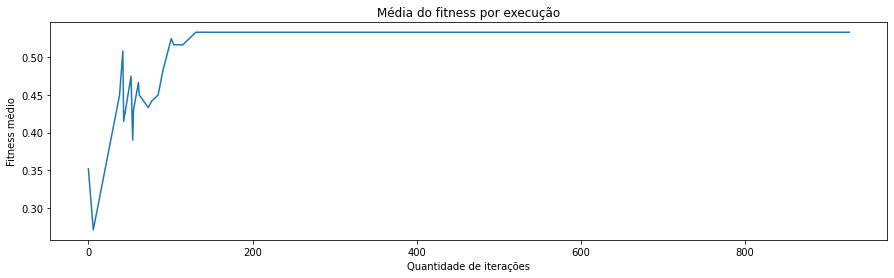

In [66]:
generateLinearPlot(df_population_size_20)

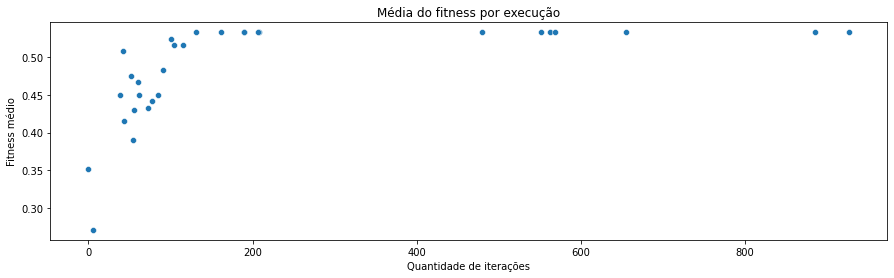

In [67]:
generateScatterPlot(df_population_size_20)

### Tamanho da população = 500

#### Hipótese
Com uma população maior é esperado que o número de iterações seja menor visto que temos mais candidatos a solução e o que fitness médio também seja menor

In [68]:
populationSize = 500

In [75]:
df_population_size_500 = run30()

Executando:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [76]:
df_population_size_500.loc[:,'iteracao'].describe()

count     30.000000
mean      98.000000
std      158.086838
min        0.000000
25%        0.000000
50%        1.000000
75%      104.500000
max      474.000000
Name: iteracao, dtype: float64

In [77]:
df_population_size_500.loc[:,'meanFitness'].describe()

count    30.000000
mean      0.347726
std       0.043700
min       0.308643
25%       0.316033
50%       0.324208
75%       0.359096
max       0.452933
Name: meanFitness, dtype: float64

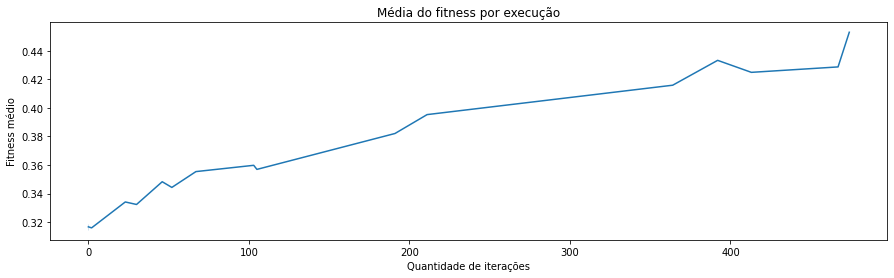

In [78]:
generateLinearPlot(df_population_size_500)

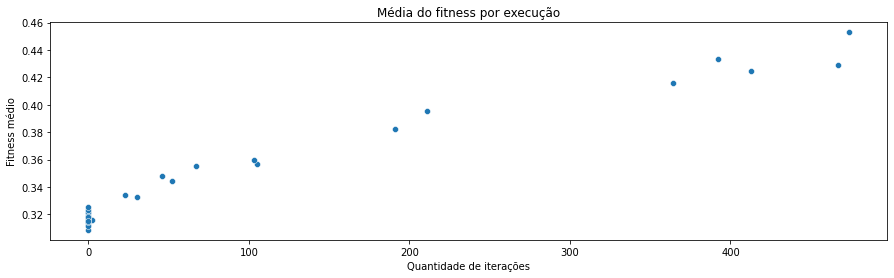

In [79]:
generateScatterPlot(df_population_size_500)

# Alterando a mutação

### Mutação por inversão

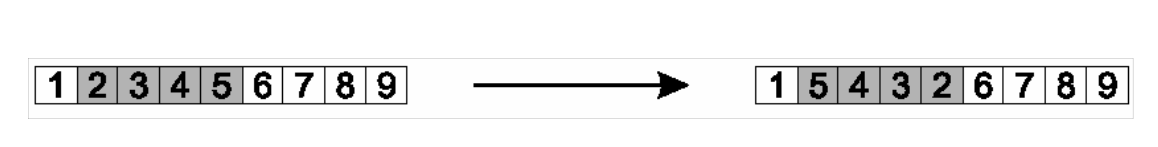

In [82]:
Image("./mutacaoInversa.png")

Escolhe-se uma sequencia de genes de forma aleatória e inverte a ordem da substring entre estes genes

##### Foi alterado apenas o operador de mutação mantendo o restante semelhante ao algoritmo do problema 1

#### Hipótese
Como a mutação é o operador responsável pela exploração em um algorítmo genético, uma mutação mais elaborada aumenta a quantidade de novas soluções que podemos encontrar. Como este problema é simples e precisamos apenas de uma solução apostar no operador de mutação não é tão útil. É esperado que o número de iterações aumente se comparado com o algoritmo original.

In [83]:
def mutacao_inversao(individuo):
    sequencia = []
    aux = individuo
    from itertools import cycle
    tamanho = randint(2,4)
    comeco = randint(0,4)
    #print('Tamanho e comeco: ', tamanho, comeco, end = ' ')
    for x in range(comeco,tamanho+comeco):
        sequencia.append(individuo['individual'][x])
    sequencia = sequencia[::-1]
    i = 0
    for y in range(comeco,tamanho+comeco):
        aux['individual'][y] = sequencia[i]
        i += 1
    return aux

In [84]:
def generateSolutionMutacaoInversa():
    populationSize = 100
    iteracaoMeanFitness = []
    population = generatePopulation()
    fitness(population)
    i = 0
    while (i < 10000) :
        iteracaoMeanFitness.append({'iteracao': i, 'meanFitness': meanFitness(population)})
        if lookingForFitnessMax(population) == True:
            break
        pai1, pai2 = selectParents(population)
        filho1 = recombination(pai1,pai2)
        filho2 = recombination(pai1,pai2)
        filho1_mutacao = mutacao_inversao(filho2)
        filho2_mutacao = mutacao_inversao(filho2)
        fitness(population)
        population = replaceElements(population, filho1_mutacao, filho2_mutacao)
        i += 1
    return maxIndividual(population), iteracaoMeanFitness

In [85]:
generateSolutionMutacaoInversa()

({'individual': ['101', '010', '110', '001', '111', '100', '000', '011'],
  'fitnessValue': 1.0},
 [{'iteracao': 0, 'meanFitness': 0.31477525807525913},
  {'iteracao': 1, 'meanFitness': 0.31038636918636886},
  {'iteracao': 2, 'meanFitness': 0.3107752580752578},
  {'iteracao': 3, 'meanFitness': 0.31107074037074006},
  {'iteracao': 4, 'meanFitness': 0.3120553557553555},
  {'iteracao': 5, 'meanFitness': 0.31303997113997095},
  {'iteracao': 6, 'meanFitness': 0.3150399711399709},
  {'iteracao': 7, 'meanFitness': 0.31637330447330425},
  {'iteracao': 8, 'meanFitness': 0.3173066378066376},
  {'iteracao': 9, 'meanFitness': 0.31778282828282806},
  {'iteracao': 10, 'meanFitness': 0.3181984126984125},
  {'iteracao': 11, 'meanFitness': 0.3186139971139969},
  {'iteracao': 12, 'meanFitness': 0.31948672438672415},
  {'iteracao': 13, 'meanFitness': 0.3199023088023086},
  {'iteracao': 14, 'meanFitness': 0.32050836940836924},
  {'iteracao': 15, 'meanFitness': 0.3217810966810965},
  {'iteracao': 16, 'mean

In [86]:
def run30MutacaoInversa():
    aux = []
    print('Executando: ', end= ' ')
    for x in range(0,30):
        print(x, end=' ')
        chess, results = generateSolutionMutacaoInversa()
        aux.append(results[-1])
    return pd.DataFrame(aux)

In [96]:
df_mutacao_inversa = run30MutacaoInversa()

Executando:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [92]:
df.loc[:,'iteracao'].describe()

count     30.000000
mean     188.666667
std      172.941555
min        0.000000
25%       15.250000
50%      159.500000
75%      291.500000
max      648.000000
Name: iteracao, dtype: float64

In [93]:
df.loc[:,'meanFitness'].describe()

count    30.000000
mean      0.448214
std       0.091979
min       0.308520
25%       0.352438
50%       0.475000
75%       0.521500
max       0.636667
Name: meanFitness, dtype: float64

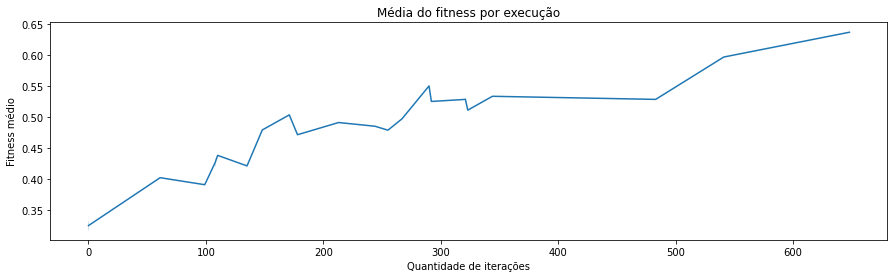

In [94]:
generateLinearPlot(df)

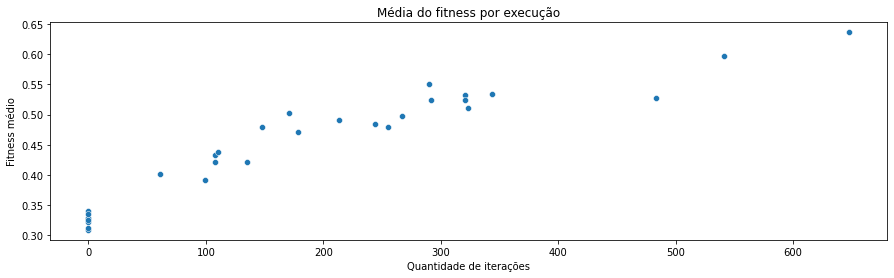

In [95]:
generateScatterPlot(df)

#### Sera que usando um novo tipo de mutação conseguimos achar uma solução em que todos os individuos da população são soluções ?

In [105]:
def allFitnessOne(populacao):
    aux = 0
    for individuo in populacao:
        if individuo['fitnessValue'] == 1:
            aux += 1
    return aux

In [110]:
def generateSolutionMutacaoInversaAllFitnessOne():
    populationSize = 100
    iteracaoMeanFitness = []
    population = generatePopulation()
    fitness(population)
    i = 0
    allFitnessOneCount = allFitnessOne(population)
    while (allFitnessOneCount != populationSize) :
        print('Quantidade de individuos com fitness 1: ', allFitnessOneCount, ', iteração: ', i)
        #iteracaoMeanFitness.append({'iteracao': i, 'meanFitness': meanFitness(population)})
        pai1, pai2 = selectParents(population)
        filho1 = recombination(pai1,pai2)
        filho2 = recombination(pai1,pai2)
        filho1_mutacao = mutacao_inversao(filho2)
        filho2_mutacao = mutacao_inversao(filho2)
        fitness(population)
        population = replaceElements(population, filho1_mutacao, filho2_mutacao)
        i += 1
        allFitnessOneCount = allFitnessOne(population)
    return population

#### Usando uma mutação mais elaborada aumenta o número de iterações para que o algoritmo convirja, já que ele procura por mais soluções mas assim ele pode retornar por uma solução onde todos os individuos tem valores otimos.

In [109]:
generateSolutionMutacaoInversaAllFitnessOne()

Quantidade de individuos com fitness 1:  2 , iteração:  0
Quantidade de individuos com fitness 1:  2 , iteração:  1
Quantidade de individuos com fitness 1:  2 , iteração:  2
Quantidade de individuos com fitness 1:  2 , iteração:  3
Quantidade de individuos com fitness 1:  2 , iteração:  4
Quantidade de individuos com fitness 1:  2 , iteração:  5
Quantidade de individuos com fitness 1:  2 , iteração:  6
Quantidade de individuos com fitness 1:  2 , iteração:  7
Quantidade de individuos com fitness 1:  2 , iteração:  8
Quantidade de individuos com fitness 1:  2 , iteração:  9
Quantidade de individuos com fitness 1:  2 , iteração:  10
Quantidade de individuos com fitness 1:  2 , iteração:  11
Quantidade de individuos com fitness 1:  2 , iteração:  12
Quantidade de individuos com fitness 1:  2 , iteração:  13
Quantidade de individuos com fitness 1:  2 , iteração:  14
Quantidade de individuos com fitness 1:  2 , iteração:  15
Quantidade de individuos com fitness 1:  2 , iteração:  16
Quantid

Quantidade de individuos com fitness 1:  4 , iteração:  141
Quantidade de individuos com fitness 1:  4 , iteração:  142
Quantidade de individuos com fitness 1:  4 , iteração:  143
Quantidade de individuos com fitness 1:  4 , iteração:  144
Quantidade de individuos com fitness 1:  4 , iteração:  145
Quantidade de individuos com fitness 1:  4 , iteração:  146
Quantidade de individuos com fitness 1:  4 , iteração:  147
Quantidade de individuos com fitness 1:  4 , iteração:  148
Quantidade de individuos com fitness 1:  4 , iteração:  149
Quantidade de individuos com fitness 1:  4 , iteração:  150
Quantidade de individuos com fitness 1:  4 , iteração:  151
Quantidade de individuos com fitness 1:  4 , iteração:  152
Quantidade de individuos com fitness 1:  4 , iteração:  153
Quantidade de individuos com fitness 1:  4 , iteração:  154
Quantidade de individuos com fitness 1:  4 , iteração:  155
Quantidade de individuos com fitness 1:  4 , iteração:  156
Quantidade de individuos com fitness 1: 

Quantidade de individuos com fitness 1:  4 , iteração:  284
Quantidade de individuos com fitness 1:  4 , iteração:  285
Quantidade de individuos com fitness 1:  4 , iteração:  286
Quantidade de individuos com fitness 1:  4 , iteração:  287
Quantidade de individuos com fitness 1:  4 , iteração:  288
Quantidade de individuos com fitness 1:  4 , iteração:  289
Quantidade de individuos com fitness 1:  4 , iteração:  290
Quantidade de individuos com fitness 1:  4 , iteração:  291
Quantidade de individuos com fitness 1:  4 , iteração:  292
Quantidade de individuos com fitness 1:  4 , iteração:  293
Quantidade de individuos com fitness 1:  4 , iteração:  294
Quantidade de individuos com fitness 1:  4 , iteração:  295
Quantidade de individuos com fitness 1:  4 , iteração:  296
Quantidade de individuos com fitness 1:  4 , iteração:  297
Quantidade de individuos com fitness 1:  4 , iteração:  298
Quantidade de individuos com fitness 1:  4 , iteração:  299
Quantidade de individuos com fitness 1: 

Quantidade de individuos com fitness 1:  8 , iteração:  423
Quantidade de individuos com fitness 1:  8 , iteração:  424
Quantidade de individuos com fitness 1:  8 , iteração:  425
Quantidade de individuos com fitness 1:  8 , iteração:  426
Quantidade de individuos com fitness 1:  8 , iteração:  427
Quantidade de individuos com fitness 1:  8 , iteração:  428
Quantidade de individuos com fitness 1:  8 , iteração:  429
Quantidade de individuos com fitness 1:  8 , iteração:  430
Quantidade de individuos com fitness 1:  8 , iteração:  431
Quantidade de individuos com fitness 1:  8 , iteração:  432
Quantidade de individuos com fitness 1:  8 , iteração:  433
Quantidade de individuos com fitness 1:  8 , iteração:  434
Quantidade de individuos com fitness 1:  8 , iteração:  435
Quantidade de individuos com fitness 1:  8 , iteração:  436
Quantidade de individuos com fitness 1:  8 , iteração:  437
Quantidade de individuos com fitness 1:  8 , iteração:  438
Quantidade de individuos com fitness 1: 

Quantidade de individuos com fitness 1:  10 , iteração:  568
Quantidade de individuos com fitness 1:  10 , iteração:  569
Quantidade de individuos com fitness 1:  10 , iteração:  570
Quantidade de individuos com fitness 1:  10 , iteração:  571
Quantidade de individuos com fitness 1:  10 , iteração:  572
Quantidade de individuos com fitness 1:  10 , iteração:  573
Quantidade de individuos com fitness 1:  10 , iteração:  574
Quantidade de individuos com fitness 1:  10 , iteração:  575
Quantidade de individuos com fitness 1:  10 , iteração:  576
Quantidade de individuos com fitness 1:  10 , iteração:  577
Quantidade de individuos com fitness 1:  10 , iteração:  578
Quantidade de individuos com fitness 1:  10 , iteração:  579
Quantidade de individuos com fitness 1:  10 , iteração:  580
Quantidade de individuos com fitness 1:  10 , iteração:  581
Quantidade de individuos com fitness 1:  10 , iteração:  582
Quantidade de individuos com fitness 1:  10 , iteração:  583
Quantidade de individuos

Quantidade de individuos com fitness 1:  10 , iteração:  711
Quantidade de individuos com fitness 1:  10 , iteração:  712
Quantidade de individuos com fitness 1:  10 , iteração:  713
Quantidade de individuos com fitness 1:  10 , iteração:  714
Quantidade de individuos com fitness 1:  10 , iteração:  715
Quantidade de individuos com fitness 1:  10 , iteração:  716
Quantidade de individuos com fitness 1:  10 , iteração:  717
Quantidade de individuos com fitness 1:  10 , iteração:  718
Quantidade de individuos com fitness 1:  10 , iteração:  719
Quantidade de individuos com fitness 1:  10 , iteração:  720
Quantidade de individuos com fitness 1:  10 , iteração:  721
Quantidade de individuos com fitness 1:  10 , iteração:  722
Quantidade de individuos com fitness 1:  10 , iteração:  723
Quantidade de individuos com fitness 1:  10 , iteração:  724
Quantidade de individuos com fitness 1:  10 , iteração:  725
Quantidade de individuos com fitness 1:  10 , iteração:  726
Quantidade de individuos

Quantidade de individuos com fitness 1:  10 , iteração:  853
Quantidade de individuos com fitness 1:  10 , iteração:  854
Quantidade de individuos com fitness 1:  10 , iteração:  855
Quantidade de individuos com fitness 1:  10 , iteração:  856
Quantidade de individuos com fitness 1:  10 , iteração:  857
Quantidade de individuos com fitness 1:  10 , iteração:  858
Quantidade de individuos com fitness 1:  10 , iteração:  859
Quantidade de individuos com fitness 1:  10 , iteração:  860
Quantidade de individuos com fitness 1:  10 , iteração:  861
Quantidade de individuos com fitness 1:  10 , iteração:  862
Quantidade de individuos com fitness 1:  10 , iteração:  863
Quantidade de individuos com fitness 1:  10 , iteração:  864
Quantidade de individuos com fitness 1:  10 , iteração:  865
Quantidade de individuos com fitness 1:  10 , iteração:  866
Quantidade de individuos com fitness 1:  10 , iteração:  867
Quantidade de individuos com fitness 1:  10 , iteração:  868
Quantidade de individuos

Quantidade de individuos com fitness 1:  10 , iteração:  992
Quantidade de individuos com fitness 1:  10 , iteração:  993
Quantidade de individuos com fitness 1:  10 , iteração:  994
Quantidade de individuos com fitness 1:  10 , iteração:  995
Quantidade de individuos com fitness 1:  10 , iteração:  996
Quantidade de individuos com fitness 1:  10 , iteração:  997
Quantidade de individuos com fitness 1:  10 , iteração:  998
Quantidade de individuos com fitness 1:  10 , iteração:  999
Quantidade de individuos com fitness 1:  10 , iteração:  1000
Quantidade de individuos com fitness 1:  10 , iteração:  1001
Quantidade de individuos com fitness 1:  10 , iteração:  1002
Quantidade de individuos com fitness 1:  10 , iteração:  1003
Quantidade de individuos com fitness 1:  10 , iteração:  1004
Quantidade de individuos com fitness 1:  10 , iteração:  1005
Quantidade de individuos com fitness 1:  10 , iteração:  1006
Quantidade de individuos com fitness 1:  10 , iteração:  1007
Quantidade de in

Quantidade de individuos com fitness 1:  12 , iteração:  1128
Quantidade de individuos com fitness 1:  12 , iteração:  1129
Quantidade de individuos com fitness 1:  12 , iteração:  1130
Quantidade de individuos com fitness 1:  12 , iteração:  1131
Quantidade de individuos com fitness 1:  12 , iteração:  1132
Quantidade de individuos com fitness 1:  12 , iteração:  1133
Quantidade de individuos com fitness 1:  12 , iteração:  1134
Quantidade de individuos com fitness 1:  12 , iteração:  1135
Quantidade de individuos com fitness 1:  12 , iteração:  1136
Quantidade de individuos com fitness 1:  12 , iteração:  1137
Quantidade de individuos com fitness 1:  12 , iteração:  1138
Quantidade de individuos com fitness 1:  12 , iteração:  1139
Quantidade de individuos com fitness 1:  12 , iteração:  1140
Quantidade de individuos com fitness 1:  12 , iteração:  1141
Quantidade de individuos com fitness 1:  12 , iteração:  1142
Quantidade de individuos com fitness 1:  12 , iteração:  1143
Quantida

Quantidade de individuos com fitness 1:  12 , iteração:  1264
Quantidade de individuos com fitness 1:  12 , iteração:  1265
Quantidade de individuos com fitness 1:  12 , iteração:  1266
Quantidade de individuos com fitness 1:  12 , iteração:  1267
Quantidade de individuos com fitness 1:  12 , iteração:  1268
Quantidade de individuos com fitness 1:  12 , iteração:  1269
Quantidade de individuos com fitness 1:  12 , iteração:  1270
Quantidade de individuos com fitness 1:  12 , iteração:  1271
Quantidade de individuos com fitness 1:  12 , iteração:  1272
Quantidade de individuos com fitness 1:  12 , iteração:  1273
Quantidade de individuos com fitness 1:  12 , iteração:  1274
Quantidade de individuos com fitness 1:  12 , iteração:  1275
Quantidade de individuos com fitness 1:  12 , iteração:  1276
Quantidade de individuos com fitness 1:  12 , iteração:  1277
Quantidade de individuos com fitness 1:  12 , iteração:  1278
Quantidade de individuos com fitness 1:  12 , iteração:  1279
Quantida

Quantidade de individuos com fitness 1:  12 , iteração:  1402
Quantidade de individuos com fitness 1:  12 , iteração:  1403
Quantidade de individuos com fitness 1:  12 , iteração:  1404
Quantidade de individuos com fitness 1:  12 , iteração:  1405
Quantidade de individuos com fitness 1:  12 , iteração:  1406
Quantidade de individuos com fitness 1:  12 , iteração:  1407
Quantidade de individuos com fitness 1:  12 , iteração:  1408
Quantidade de individuos com fitness 1:  12 , iteração:  1409
Quantidade de individuos com fitness 1:  12 , iteração:  1410
Quantidade de individuos com fitness 1:  12 , iteração:  1411
Quantidade de individuos com fitness 1:  12 , iteração:  1412
Quantidade de individuos com fitness 1:  12 , iteração:  1413
Quantidade de individuos com fitness 1:  12 , iteração:  1414
Quantidade de individuos com fitness 1:  12 , iteração:  1415
Quantidade de individuos com fitness 1:  12 , iteração:  1416
Quantidade de individuos com fitness 1:  12 , iteração:  1417
Quantida

Quantidade de individuos com fitness 1:  16 , iteração:  1539
Quantidade de individuos com fitness 1:  16 , iteração:  1540
Quantidade de individuos com fitness 1:  16 , iteração:  1541
Quantidade de individuos com fitness 1:  16 , iteração:  1542
Quantidade de individuos com fitness 1:  16 , iteração:  1543
Quantidade de individuos com fitness 1:  16 , iteração:  1544
Quantidade de individuos com fitness 1:  16 , iteração:  1545
Quantidade de individuos com fitness 1:  16 , iteração:  1546
Quantidade de individuos com fitness 1:  16 , iteração:  1547
Quantidade de individuos com fitness 1:  16 , iteração:  1548
Quantidade de individuos com fitness 1:  16 , iteração:  1549
Quantidade de individuos com fitness 1:  16 , iteração:  1550
Quantidade de individuos com fitness 1:  16 , iteração:  1551
Quantidade de individuos com fitness 1:  16 , iteração:  1552
Quantidade de individuos com fitness 1:  16 , iteração:  1553
Quantidade de individuos com fitness 1:  16 , iteração:  1554
Quantida

Quantidade de individuos com fitness 1:  16 , iteração:  1674
Quantidade de individuos com fitness 1:  16 , iteração:  1675
Quantidade de individuos com fitness 1:  16 , iteração:  1676
Quantidade de individuos com fitness 1:  16 , iteração:  1677
Quantidade de individuos com fitness 1:  16 , iteração:  1678
Quantidade de individuos com fitness 1:  16 , iteração:  1679
Quantidade de individuos com fitness 1:  16 , iteração:  1680
Quantidade de individuos com fitness 1:  18 , iteração:  1681
Quantidade de individuos com fitness 1:  18 , iteração:  1682
Quantidade de individuos com fitness 1:  18 , iteração:  1683
Quantidade de individuos com fitness 1:  18 , iteração:  1684
Quantidade de individuos com fitness 1:  18 , iteração:  1685
Quantidade de individuos com fitness 1:  18 , iteração:  1686
Quantidade de individuos com fitness 1:  18 , iteração:  1687
Quantidade de individuos com fitness 1:  18 , iteração:  1688
Quantidade de individuos com fitness 1:  18 , iteração:  1689
Quantida

Quantidade de individuos com fitness 1:  24 , iteração:  1816
Quantidade de individuos com fitness 1:  24 , iteração:  1817
Quantidade de individuos com fitness 1:  24 , iteração:  1818
Quantidade de individuos com fitness 1:  24 , iteração:  1819
Quantidade de individuos com fitness 1:  24 , iteração:  1820
Quantidade de individuos com fitness 1:  24 , iteração:  1821
Quantidade de individuos com fitness 1:  24 , iteração:  1822
Quantidade de individuos com fitness 1:  24 , iteração:  1823
Quantidade de individuos com fitness 1:  24 , iteração:  1824
Quantidade de individuos com fitness 1:  24 , iteração:  1825
Quantidade de individuos com fitness 1:  24 , iteração:  1826
Quantidade de individuos com fitness 1:  24 , iteração:  1827
Quantidade de individuos com fitness 1:  24 , iteração:  1828
Quantidade de individuos com fitness 1:  24 , iteração:  1829
Quantidade de individuos com fitness 1:  24 , iteração:  1830
Quantidade de individuos com fitness 1:  24 , iteração:  1831
Quantida

Quantidade de individuos com fitness 1:  26 , iteração:  1959
Quantidade de individuos com fitness 1:  26 , iteração:  1960
Quantidade de individuos com fitness 1:  26 , iteração:  1961
Quantidade de individuos com fitness 1:  26 , iteração:  1962
Quantidade de individuos com fitness 1:  26 , iteração:  1963
Quantidade de individuos com fitness 1:  26 , iteração:  1964
Quantidade de individuos com fitness 1:  26 , iteração:  1965
Quantidade de individuos com fitness 1:  26 , iteração:  1966
Quantidade de individuos com fitness 1:  26 , iteração:  1967
Quantidade de individuos com fitness 1:  26 , iteração:  1968
Quantidade de individuos com fitness 1:  26 , iteração:  1969
Quantidade de individuos com fitness 1:  26 , iteração:  1970
Quantidade de individuos com fitness 1:  26 , iteração:  1971
Quantidade de individuos com fitness 1:  26 , iteração:  1972
Quantidade de individuos com fitness 1:  26 , iteração:  1973
Quantidade de individuos com fitness 1:  26 , iteração:  1974
Quantida

Quantidade de individuos com fitness 1:  32 , iteração:  2093
Quantidade de individuos com fitness 1:  32 , iteração:  2094
Quantidade de individuos com fitness 1:  32 , iteração:  2095
Quantidade de individuos com fitness 1:  32 , iteração:  2096
Quantidade de individuos com fitness 1:  32 , iteração:  2097
Quantidade de individuos com fitness 1:  32 , iteração:  2098
Quantidade de individuos com fitness 1:  32 , iteração:  2099
Quantidade de individuos com fitness 1:  32 , iteração:  2100
Quantidade de individuos com fitness 1:  32 , iteração:  2101
Quantidade de individuos com fitness 1:  32 , iteração:  2102
Quantidade de individuos com fitness 1:  32 , iteração:  2103
Quantidade de individuos com fitness 1:  32 , iteração:  2104
Quantidade de individuos com fitness 1:  32 , iteração:  2105
Quantidade de individuos com fitness 1:  32 , iteração:  2106
Quantidade de individuos com fitness 1:  32 , iteração:  2107
Quantidade de individuos com fitness 1:  32 , iteração:  2108
Quantida

Quantidade de individuos com fitness 1:  34 , iteração:  2234
Quantidade de individuos com fitness 1:  34 , iteração:  2235
Quantidade de individuos com fitness 1:  34 , iteração:  2236
Quantidade de individuos com fitness 1:  34 , iteração:  2237
Quantidade de individuos com fitness 1:  34 , iteração:  2238
Quantidade de individuos com fitness 1:  34 , iteração:  2239
Quantidade de individuos com fitness 1:  34 , iteração:  2240
Quantidade de individuos com fitness 1:  34 , iteração:  2241
Quantidade de individuos com fitness 1:  34 , iteração:  2242
Quantidade de individuos com fitness 1:  34 , iteração:  2243
Quantidade de individuos com fitness 1:  34 , iteração:  2244
Quantidade de individuos com fitness 1:  34 , iteração:  2245
Quantidade de individuos com fitness 1:  34 , iteração:  2246
Quantidade de individuos com fitness 1:  34 , iteração:  2247
Quantidade de individuos com fitness 1:  34 , iteração:  2248
Quantidade de individuos com fitness 1:  34 , iteração:  2249
Quantida

Quantidade de individuos com fitness 1:  34 , iteração:  2367
Quantidade de individuos com fitness 1:  34 , iteração:  2368
Quantidade de individuos com fitness 1:  34 , iteração:  2369
Quantidade de individuos com fitness 1:  34 , iteração:  2370
Quantidade de individuos com fitness 1:  34 , iteração:  2371
Quantidade de individuos com fitness 1:  34 , iteração:  2372
Quantidade de individuos com fitness 1:  34 , iteração:  2373
Quantidade de individuos com fitness 1:  34 , iteração:  2374
Quantidade de individuos com fitness 1:  34 , iteração:  2375
Quantidade de individuos com fitness 1:  34 , iteração:  2376
Quantidade de individuos com fitness 1:  34 , iteração:  2377
Quantidade de individuos com fitness 1:  34 , iteração:  2378
Quantidade de individuos com fitness 1:  34 , iteração:  2379
Quantidade de individuos com fitness 1:  34 , iteração:  2380
Quantidade de individuos com fitness 1:  34 , iteração:  2381
Quantidade de individuos com fitness 1:  34 , iteração:  2382
Quantida

Quantidade de individuos com fitness 1:  40 , iteração:  2513
Quantidade de individuos com fitness 1:  40 , iteração:  2514
Quantidade de individuos com fitness 1:  40 , iteração:  2515
Quantidade de individuos com fitness 1:  40 , iteração:  2516
Quantidade de individuos com fitness 1:  40 , iteração:  2517
Quantidade de individuos com fitness 1:  40 , iteração:  2518
Quantidade de individuos com fitness 1:  40 , iteração:  2519
Quantidade de individuos com fitness 1:  40 , iteração:  2520
Quantidade de individuos com fitness 1:  40 , iteração:  2521
Quantidade de individuos com fitness 1:  40 , iteração:  2522
Quantidade de individuos com fitness 1:  40 , iteração:  2523
Quantidade de individuos com fitness 1:  40 , iteração:  2524
Quantidade de individuos com fitness 1:  40 , iteração:  2525
Quantidade de individuos com fitness 1:  40 , iteração:  2526
Quantidade de individuos com fitness 1:  40 , iteração:  2527
Quantidade de individuos com fitness 1:  40 , iteração:  2528
Quantida

Quantidade de individuos com fitness 1:  42 , iteração:  2664
Quantidade de individuos com fitness 1:  42 , iteração:  2665
Quantidade de individuos com fitness 1:  42 , iteração:  2666
Quantidade de individuos com fitness 1:  42 , iteração:  2667
Quantidade de individuos com fitness 1:  42 , iteração:  2668
Quantidade de individuos com fitness 1:  42 , iteração:  2669
Quantidade de individuos com fitness 1:  42 , iteração:  2670
Quantidade de individuos com fitness 1:  42 , iteração:  2671
Quantidade de individuos com fitness 1:  42 , iteração:  2672
Quantidade de individuos com fitness 1:  42 , iteração:  2673
Quantidade de individuos com fitness 1:  42 , iteração:  2674
Quantidade de individuos com fitness 1:  42 , iteração:  2675
Quantidade de individuos com fitness 1:  42 , iteração:  2676
Quantidade de individuos com fitness 1:  42 , iteração:  2677
Quantidade de individuos com fitness 1:  42 , iteração:  2678
Quantidade de individuos com fitness 1:  42 , iteração:  2679
Quantida

Quantidade de individuos com fitness 1:  46 , iteração:  2798
Quantidade de individuos com fitness 1:  46 , iteração:  2799
Quantidade de individuos com fitness 1:  46 , iteração:  2800
Quantidade de individuos com fitness 1:  46 , iteração:  2801
Quantidade de individuos com fitness 1:  46 , iteração:  2802
Quantidade de individuos com fitness 1:  46 , iteração:  2803
Quantidade de individuos com fitness 1:  48 , iteração:  2804
Quantidade de individuos com fitness 1:  48 , iteração:  2805
Quantidade de individuos com fitness 1:  48 , iteração:  2806
Quantidade de individuos com fitness 1:  48 , iteração:  2807
Quantidade de individuos com fitness 1:  48 , iteração:  2808
Quantidade de individuos com fitness 1:  48 , iteração:  2809
Quantidade de individuos com fitness 1:  48 , iteração:  2810
Quantidade de individuos com fitness 1:  48 , iteração:  2811
Quantidade de individuos com fitness 1:  48 , iteração:  2812
Quantidade de individuos com fitness 1:  48 , iteração:  2813
Quantida

Quantidade de individuos com fitness 1:  52 , iteração:  2944
Quantidade de individuos com fitness 1:  52 , iteração:  2945
Quantidade de individuos com fitness 1:  52 , iteração:  2946
Quantidade de individuos com fitness 1:  52 , iteração:  2947
Quantidade de individuos com fitness 1:  52 , iteração:  2948
Quantidade de individuos com fitness 1:  52 , iteração:  2949
Quantidade de individuos com fitness 1:  52 , iteração:  2950
Quantidade de individuos com fitness 1:  52 , iteração:  2951
Quantidade de individuos com fitness 1:  52 , iteração:  2952
Quantidade de individuos com fitness 1:  52 , iteração:  2953
Quantidade de individuos com fitness 1:  52 , iteração:  2954
Quantidade de individuos com fitness 1:  52 , iteração:  2955
Quantidade de individuos com fitness 1:  52 , iteração:  2956
Quantidade de individuos com fitness 1:  52 , iteração:  2957
Quantidade de individuos com fitness 1:  52 , iteração:  2958
Quantidade de individuos com fitness 1:  52 , iteração:  2959
Quantida

Quantidade de individuos com fitness 1:  56 , iteração:  3099
Quantidade de individuos com fitness 1:  56 , iteração:  3100
Quantidade de individuos com fitness 1:  56 , iteração:  3101
Quantidade de individuos com fitness 1:  56 , iteração:  3102
Quantidade de individuos com fitness 1:  56 , iteração:  3103
Quantidade de individuos com fitness 1:  56 , iteração:  3104
Quantidade de individuos com fitness 1:  56 , iteração:  3105
Quantidade de individuos com fitness 1:  56 , iteração:  3106
Quantidade de individuos com fitness 1:  56 , iteração:  3107
Quantidade de individuos com fitness 1:  58 , iteração:  3108
Quantidade de individuos com fitness 1:  58 , iteração:  3109
Quantidade de individuos com fitness 1:  58 , iteração:  3110
Quantidade de individuos com fitness 1:  58 , iteração:  3111
Quantidade de individuos com fitness 1:  58 , iteração:  3112
Quantidade de individuos com fitness 1:  58 , iteração:  3113
Quantidade de individuos com fitness 1:  58 , iteração:  3114
Quantida

Quantidade de individuos com fitness 1:  60 , iteração:  3233
Quantidade de individuos com fitness 1:  60 , iteração:  3234
Quantidade de individuos com fitness 1:  60 , iteração:  3235
Quantidade de individuos com fitness 1:  60 , iteração:  3236
Quantidade de individuos com fitness 1:  60 , iteração:  3237
Quantidade de individuos com fitness 1:  60 , iteração:  3238
Quantidade de individuos com fitness 1:  60 , iteração:  3239
Quantidade de individuos com fitness 1:  60 , iteração:  3240
Quantidade de individuos com fitness 1:  60 , iteração:  3241
Quantidade de individuos com fitness 1:  60 , iteração:  3242
Quantidade de individuos com fitness 1:  60 , iteração:  3243
Quantidade de individuos com fitness 1:  60 , iteração:  3244
Quantidade de individuos com fitness 1:  60 , iteração:  3245
Quantidade de individuos com fitness 1:  60 , iteração:  3246
Quantidade de individuos com fitness 1:  60 , iteração:  3247
Quantidade de individuos com fitness 1:  60 , iteração:  3248
Quantida

Quantidade de individuos com fitness 1:  70 , iteração:  3387
Quantidade de individuos com fitness 1:  70 , iteração:  3388
Quantidade de individuos com fitness 1:  70 , iteração:  3389
Quantidade de individuos com fitness 1:  70 , iteração:  3390
Quantidade de individuos com fitness 1:  70 , iteração:  3391
Quantidade de individuos com fitness 1:  70 , iteração:  3392
Quantidade de individuos com fitness 1:  70 , iteração:  3393
Quantidade de individuos com fitness 1:  70 , iteração:  3394
Quantidade de individuos com fitness 1:  72 , iteração:  3395
Quantidade de individuos com fitness 1:  72 , iteração:  3396
Quantidade de individuos com fitness 1:  72 , iteração:  3397
Quantidade de individuos com fitness 1:  72 , iteração:  3398
Quantidade de individuos com fitness 1:  72 , iteração:  3399
Quantidade de individuos com fitness 1:  72 , iteração:  3400
Quantidade de individuos com fitness 1:  72 , iteração:  3401
Quantidade de individuos com fitness 1:  72 , iteração:  3402
Quantida

Quantidade de individuos com fitness 1:  74 , iteração:  3525
Quantidade de individuos com fitness 1:  74 , iteração:  3526
Quantidade de individuos com fitness 1:  74 , iteração:  3527
Quantidade de individuos com fitness 1:  74 , iteração:  3528
Quantidade de individuos com fitness 1:  74 , iteração:  3529
Quantidade de individuos com fitness 1:  74 , iteração:  3530
Quantidade de individuos com fitness 1:  74 , iteração:  3531
Quantidade de individuos com fitness 1:  74 , iteração:  3532
Quantidade de individuos com fitness 1:  74 , iteração:  3533
Quantidade de individuos com fitness 1:  74 , iteração:  3534
Quantidade de individuos com fitness 1:  74 , iteração:  3535
Quantidade de individuos com fitness 1:  74 , iteração:  3536
Quantidade de individuos com fitness 1:  74 , iteração:  3537
Quantidade de individuos com fitness 1:  74 , iteração:  3538
Quantidade de individuos com fitness 1:  74 , iteração:  3539
Quantidade de individuos com fitness 1:  74 , iteração:  3540
Quantida

Quantidade de individuos com fitness 1:  84 , iteração:  3675
Quantidade de individuos com fitness 1:  84 , iteração:  3676
Quantidade de individuos com fitness 1:  84 , iteração:  3677
Quantidade de individuos com fitness 1:  84 , iteração:  3678
Quantidade de individuos com fitness 1:  84 , iteração:  3679
Quantidade de individuos com fitness 1:  84 , iteração:  3680
Quantidade de individuos com fitness 1:  84 , iteração:  3681
Quantidade de individuos com fitness 1:  84 , iteração:  3682
Quantidade de individuos com fitness 1:  84 , iteração:  3683
Quantidade de individuos com fitness 1:  84 , iteração:  3684
Quantidade de individuos com fitness 1:  84 , iteração:  3685
Quantidade de individuos com fitness 1:  84 , iteração:  3686
Quantidade de individuos com fitness 1:  84 , iteração:  3687
Quantidade de individuos com fitness 1:  84 , iteração:  3688
Quantidade de individuos com fitness 1:  84 , iteração:  3689
Quantidade de individuos com fitness 1:  84 , iteração:  3690
Quantida

Quantidade de individuos com fitness 1:  84 , iteração:  3835
Quantidade de individuos com fitness 1:  84 , iteração:  3836
Quantidade de individuos com fitness 1:  84 , iteração:  3837
Quantidade de individuos com fitness 1:  84 , iteração:  3838
Quantidade de individuos com fitness 1:  84 , iteração:  3839
Quantidade de individuos com fitness 1:  84 , iteração:  3840
Quantidade de individuos com fitness 1:  84 , iteração:  3841
Quantidade de individuos com fitness 1:  84 , iteração:  3842
Quantidade de individuos com fitness 1:  84 , iteração:  3843
Quantidade de individuos com fitness 1:  84 , iteração:  3844
Quantidade de individuos com fitness 1:  84 , iteração:  3845
Quantidade de individuos com fitness 1:  84 , iteração:  3846
Quantidade de individuos com fitness 1:  86 , iteração:  3847
Quantidade de individuos com fitness 1:  86 , iteração:  3848
Quantidade de individuos com fitness 1:  86 , iteração:  3849
Quantidade de individuos com fitness 1:  86 , iteração:  3850
Quantida

Quantidade de individuos com fitness 1:  92 , iteração:  3996
Quantidade de individuos com fitness 1:  92 , iteração:  3997
Quantidade de individuos com fitness 1:  92 , iteração:  3998
Quantidade de individuos com fitness 1:  92 , iteração:  3999
Quantidade de individuos com fitness 1:  92 , iteração:  4000
Quantidade de individuos com fitness 1:  92 , iteração:  4001
Quantidade de individuos com fitness 1:  92 , iteração:  4002
Quantidade de individuos com fitness 1:  92 , iteração:  4003
Quantidade de individuos com fitness 1:  92 , iteração:  4004
Quantidade de individuos com fitness 1:  92 , iteração:  4005
Quantidade de individuos com fitness 1:  92 , iteração:  4006
Quantidade de individuos com fitness 1:  92 , iteração:  4007
Quantidade de individuos com fitness 1:  92 , iteração:  4008
Quantidade de individuos com fitness 1:  92 , iteração:  4009
Quantidade de individuos com fitness 1:  92 , iteração:  4010
Quantidade de individuos com fitness 1:  92 , iteração:  4011
Quantida

Quantidade de individuos com fitness 1:  96 , iteração:  4132
Quantidade de individuos com fitness 1:  96 , iteração:  4133
Quantidade de individuos com fitness 1:  96 , iteração:  4134
Quantidade de individuos com fitness 1:  96 , iteração:  4135
Quantidade de individuos com fitness 1:  96 , iteração:  4136
Quantidade de individuos com fitness 1:  96 , iteração:  4137
Quantidade de individuos com fitness 1:  96 , iteração:  4138
Quantidade de individuos com fitness 1:  96 , iteração:  4139
Quantidade de individuos com fitness 1:  96 , iteração:  4140
Quantidade de individuos com fitness 1:  96 , iteração:  4141
Quantidade de individuos com fitness 1:  96 , iteração:  4142
Quantidade de individuos com fitness 1:  96 , iteração:  4143
Quantidade de individuos com fitness 1:  96 , iteração:  4144
Quantidade de individuos com fitness 1:  96 , iteração:  4145
Quantidade de individuos com fitness 1:  96 , iteração:  4146
Quantidade de individuos com fitness 1:  96 , iteração:  4147
Quantida

Quantidade de individuos com fitness 1:  98 , iteração:  4274
Quantidade de individuos com fitness 1:  98 , iteração:  4275
Quantidade de individuos com fitness 1:  98 , iteração:  4276
Quantidade de individuos com fitness 1:  98 , iteração:  4277
Quantidade de individuos com fitness 1:  98 , iteração:  4278
Quantidade de individuos com fitness 1:  98 , iteração:  4279
Quantidade de individuos com fitness 1:  98 , iteração:  4280
Quantidade de individuos com fitness 1:  98 , iteração:  4281
Quantidade de individuos com fitness 1:  98 , iteração:  4282
Quantidade de individuos com fitness 1:  98 , iteração:  4283
Quantidade de individuos com fitness 1:  98 , iteração:  4284
Quantidade de individuos com fitness 1:  98 , iteração:  4285
Quantidade de individuos com fitness 1:  98 , iteração:  4286
Quantidade de individuos com fitness 1:  98 , iteração:  4287
Quantidade de individuos com fitness 1:  98 , iteração:  4288
Quantidade de individuos com fitness 1:  98 , iteração:  4289
Quantida

[{'individual': ['100', '110', '010', '000', '101', '001', '011', '111'],
  'fitnessValue': -1},
 {'individual': ['100', '110', '010', '000', '101', '001', '011', '111'],
  'fitnessValue': -1},
 {'individual': ['101', '001', '100', '111', '010', '110', '011', '000'],
  'fitnessValue': 0.6666666666666666},
 {'individual': ['101', '001', '100', '111', '010', '110', '011', '000'],
  'fitnessValue': 0.6666666666666666},
 {'individual': ['011', '111', '100', '001', '101', '010', '000', '110'],
  'fitnessValue': 0.6666666666666666},
 {'individual': ['011', '111', '100', '001', '101', '010', '000', '110'],
  'fitnessValue': 0.6666666666666666},
 {'individual': ['011', '110', '010', '111', '101', '000', '100', '001'],
  'fitnessValue': 0.6666666666666666},
 {'individual': ['011', '110', '010', '111', '101', '000', '100', '001'],
  'fitnessValue': 0.6666666666666666},
 {'individual': ['100', '110', '000', '010', '101', '111', '001', '011'],
  'fitnessValue': 0.6666666666666666},
 {'individual':

# Alterando o tipo de seleção dos país

### Usando o método da roleta

#### Hipótese
O método da roleta permite explorar um pouco melhor a diversidade da população mas ainda deixando claro que os melhores indivíduos tem mais chance de serem escolhidos para reprodução. Aumentando a diversidade da população diminuimos a chance de cairmos em máximos locais

#### Recombinação roleta

In [111]:
def insertValuesSecondParentRoleta(parent, point, son):
    parentCircular = generateParentTwoAux(parent, point)
    while(len(son) != 8):
            for x in parentCircular:
                if not x in son: # Se o valor do 2 pai ainda não existe no filho insere
                    son.append(x)
    return {'individual': son, 'fitnessValue': 0, 'roleta': 0 }

In [112]:
def recombinationRoleta(parent_one, parent_two):
    son = []
    point = randint(0,7) # Escolher uma posição para executar
    chooseFirst = randint(0,1)
    if (chooseFirst == 0):
        son = copyFirstParent(parent_one, point) # Se o primeiro pai for escolhido o filho recebera primeiro os genes dele
        return insertValuesSecondParentRoleta(parent_two, point, son)
    else:
        son = copyFirstParent(parent_two, point) # Se o segundo pai for escolhido o filho recebera primeiro os genes dele
        return insertValuesSecondParentRoleta(parent_one, point, son)

#### Preciso criar uma população com o atributo probabilidade

In [113]:
def gerarPopulacaoComAtributosRoleta():
    populationSize = 100
    aux = []
    for populationMember in range(populationSize):
        aux.append({'individual': generateChess() , 'fitnessValue': -1, 'roleta': 0 }) 
        #Cria um objeto composto do individuo, seu valor de fitness e valores relacionados a seleção de pais  
    return aux

#### Zerar roleta

In [114]:
def zerarRoleta(populacao):
    for individuo in populacao:
        individuo['roleta'] = 0

#### Calculando valores da roleta

In [115]:
def calcularValoresRoleta(populacao):
    for i in range(0, len(populacao)):
        if i == 0:
            populacao[i]['roleta'] = populacao[i]['fitnessValue']
        else:
            populacao[i]['roleta'] = populacao[i]['fitnessValue'] + populacao[i-1]['roleta']

#### Selecionando o pai

In [116]:
def escolherPaiUsandoRoleta(populacao, maxValueRoleta):
    giroRoleta = random.uniform(0, maxValueRoleta)
    for individuo in populacao:
        if individuo['roleta'] >= giroRoleta:
            return individuo

#### Max value

In [117]:
def maxValue(populacao):
    aux = []
    for individuo in populacao:
        aux.append(individuo['fitnessValue'])
    return max(aux)

#### Fitness roleta

In [118]:
def fitnessIndividual(individual):
    value = 1 / (1 + (columnThreaten(individual) + diagonalThreaten(individual)))
    return truncate(value)

In [119]:
def fitness(population):
    fitnessValue = []
    for individual in population:
        individual['fitnessValue'] = fitnessIndividual(individual['individual'])

#### método principal da roleta

In [120]:
def roleta(populacao):
    calcularValoresRoleta(populacao)
    maxValueRoleta = maxValue(populacao)
    pai = escolherPaiUsandoRoleta(populacao, maxValueRoleta)
    return pai

In [129]:
def generateSolutionRoleta():
    populationSize = 100
    iteracaoMeanFitness = []
    population = gerarPopulacaoComAtributosRoleta()
    fitness(population)
    i = 0
    while (i < 10000) :
        iteracaoMeanFitness.append({'iteracao': i, 'meanFitness': meanFitness(population)})
        if lookingForFitnessMax(population) == True:
            break
        pai1 = roleta(population)
        pai2 = roleta(population)
        zerarRoleta(population)
        filho1 = recombinationRoleta(pai1,pai2)
        filho2 = recombinationRoleta(pai1,pai2)
        filho1_mutacao = mutationSwap(filho2)
        filho2_mutacao = mutationSwap(filho2)
        fitness(population)
        population = replaceElements(population, filho1_mutacao, filho2_mutacao)
        i += 1
    return maxIndividual(population), iteracaoMeanFitness

#### Gerando uma solução de exemplo

In [130]:
generateSolutionRoleta()

({'individual': ['110', '011', '001', '111', '101', '000', '010', '100'],
  'fitnessValue': 1.0,
  'roleta': 0},
 [{'iteracao': 0, 'meanFitness': 0.05871480000000001},
  {'iteracao': 1, 'meanFitness': 0.05825439999999997},
  {'iteracao': 2, 'meanFitness': 0.058803999999999974},
  {'iteracao': 3, 'meanFitness': 0.05978879999999996},
  {'iteracao': 4, 'meanFitness': 0.06069199999999995},
  {'iteracao': 5, 'meanFitness': 0.06069199999999995},
  {'iteracao': 6, 'meanFitness': 0.06129799999999995},
  {'iteracao': 7, 'meanFitness': 0.06129799999999995},
  {'iteracao': 8, 'meanFitness': 0.061903999999999945},
  {'iteracao': 9, 'meanFitness': 0.062176799999999956},
  {'iteracao': 10, 'meanFitness': 0.06270999999999996},
  {'iteracao': 11, 'meanFitness': 0.06279879999999996},
  {'iteracao': 12, 'meanFitness': 0.06309719999999996},
  {'iteracao': 13, 'meanFitness': 0.06309719999999996},
  {'iteracao': 14, 'meanFitness': 0.06354159999999996},
  {'iteracao': 15, 'meanFitness': 0.06379559999999995}

#### Rodando o código com a seleção usando roleta 30 vezes

In [131]:
def run30Roleta():
    aux = []
    print('Executando: ', end= ' ')
    for x in range(0,30):
        print(x, end=' ')
        chess, results = generateSolutionRoleta()
        aux.append(results[-1])
    return pd.DataFrame(aux)    

In [132]:
df_roleta = run30Roleta()

Executando:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [133]:
df_roleta.loc[:,'iteracao'].describe()

count     30.000000
mean     176.033333
std      170.800041
min        0.000000
25%       59.750000
50%      160.500000
75%      237.000000
max      795.000000
Name: iteracao, dtype: float64

In [134]:
df_roleta.loc[:,'meanFitness'].describe()

count    30.000000
mean      0.087685
std       0.014230
min       0.063940
25%       0.080163
50%       0.090999
75%       0.094932
max       0.122324
Name: meanFitness, dtype: float64

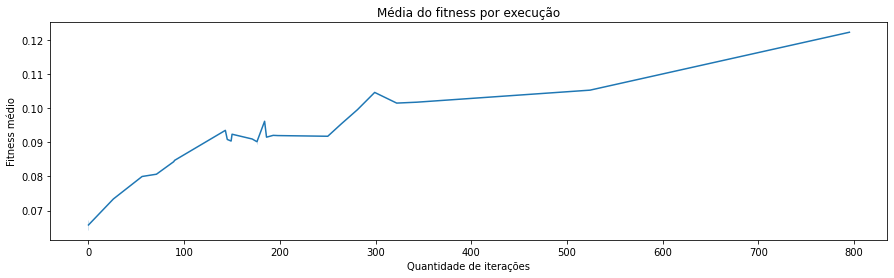

In [135]:
generateLinearPlot(df_roleta)

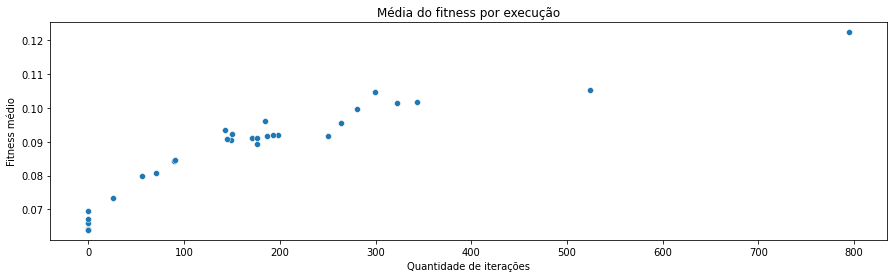

In [136]:
generateScatterPlot(df_roleta)